In [1]:
%pip install -q -U --no-warn-conflicts malariagen_data
%pip install -q --no-warn-conflicts petl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 6

In [2]:
import malariagen_data
import allel
import numpy as np
import numba
from numba import njit
import pandas as pd
import functools
#import dask
from dask.diagnostics.progress import ProgressBar
#dask.config.set(**{'array.slicing.split_large_chunks': True})
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.legend import Legend
#import matplotlib_venn as venn
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
import scipy
import scipy.cluster
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy
from scipy.cluster.hierarchy import dendrogram, fcluster, leaves_list, set_link_color_palette

In [4]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive/"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [5]:
## Importing malariagen data set
ag3 = malariagen_data.Ag3("gs://vo_agam_release_master_us_central1/", pre=True)
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release_master_us_central1/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 3.10, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16
Results cache           : None
Cohorts analysis        : 20250815
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 15.4.0
Client location         : South Carolina, United States (Google Cloud us-east1)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v15.4.0/Ag3.html

In [6]:
df_samples=ag3.sample_metadata(sample_sets='3.11', sample_query='country=="Burkina Faso"')
sets = list(df_samples.sample_set.unique())

In [7]:
## transcrit and region
region = "2L:2358158-2431617"
transcript = 'AGAP004707-RD'

#To access to the genotypes within the 3L chromosomes
ds_snps = ag3.snp_calls(region="2L:2358158-2431617", sample_sets=sets)

# Take some SNP in the X chromosomes
ds_pos = allel.SortedIndex(ds_snps['variant_position'].values)

# To filter the SNP dataset and warp the dataset to GT array
filt = 'gamb_colu_arab'
filt_val = ds_snps[f"variant_filter_pass_{filt}"].values

## Compute genotype & count the number of alleles
with ProgressBar():
  ds_gt = allel.GenotypeArray(ds_snps["call_genotype"][filt_val].data)
  ds_ac = ds_gt.count_alleles()

[########################################] | 100% Completed | 7.99 s


In [8]:
# gives the haplotype indices of the haplotypes in the n largest clusters
def find_clusters(z, n, threshold=12):

    # find clusters
    f = scipy.cluster.hierarchy.fcluster(z, threshold, criterion='distance')

    # compute cluster sizes
    fsz = np.bincount(f)

    # sort largest first
    fsort = np.argsort(fsz)[::-1]

    # take largest n
    fsort = fsort[:n]

    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]

    return clusters

def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)

## Diplotype clustering

In [9]:
hs=ds_gt.to_n_alt()
dist = allel.pairwise_distance(hs, 'hamming') * hs.shape[0]
method='complete'
n = int(scipy.cluster.hierarchy.distance.num_obs_y(dist))
method = dict(single=0, complete=1)[method]
y = np.asarray(dist, order='c', dtype=np.double)
z = scipy.cluster.hierarchy._hierarchy.linkage(y, n, method)

In [10]:
#dist1 = allel.pairwise_distance(hs, 'hamming')
#dist2 = allel.pairwise_distance(hs, 'hamming') * hs.shape[0]

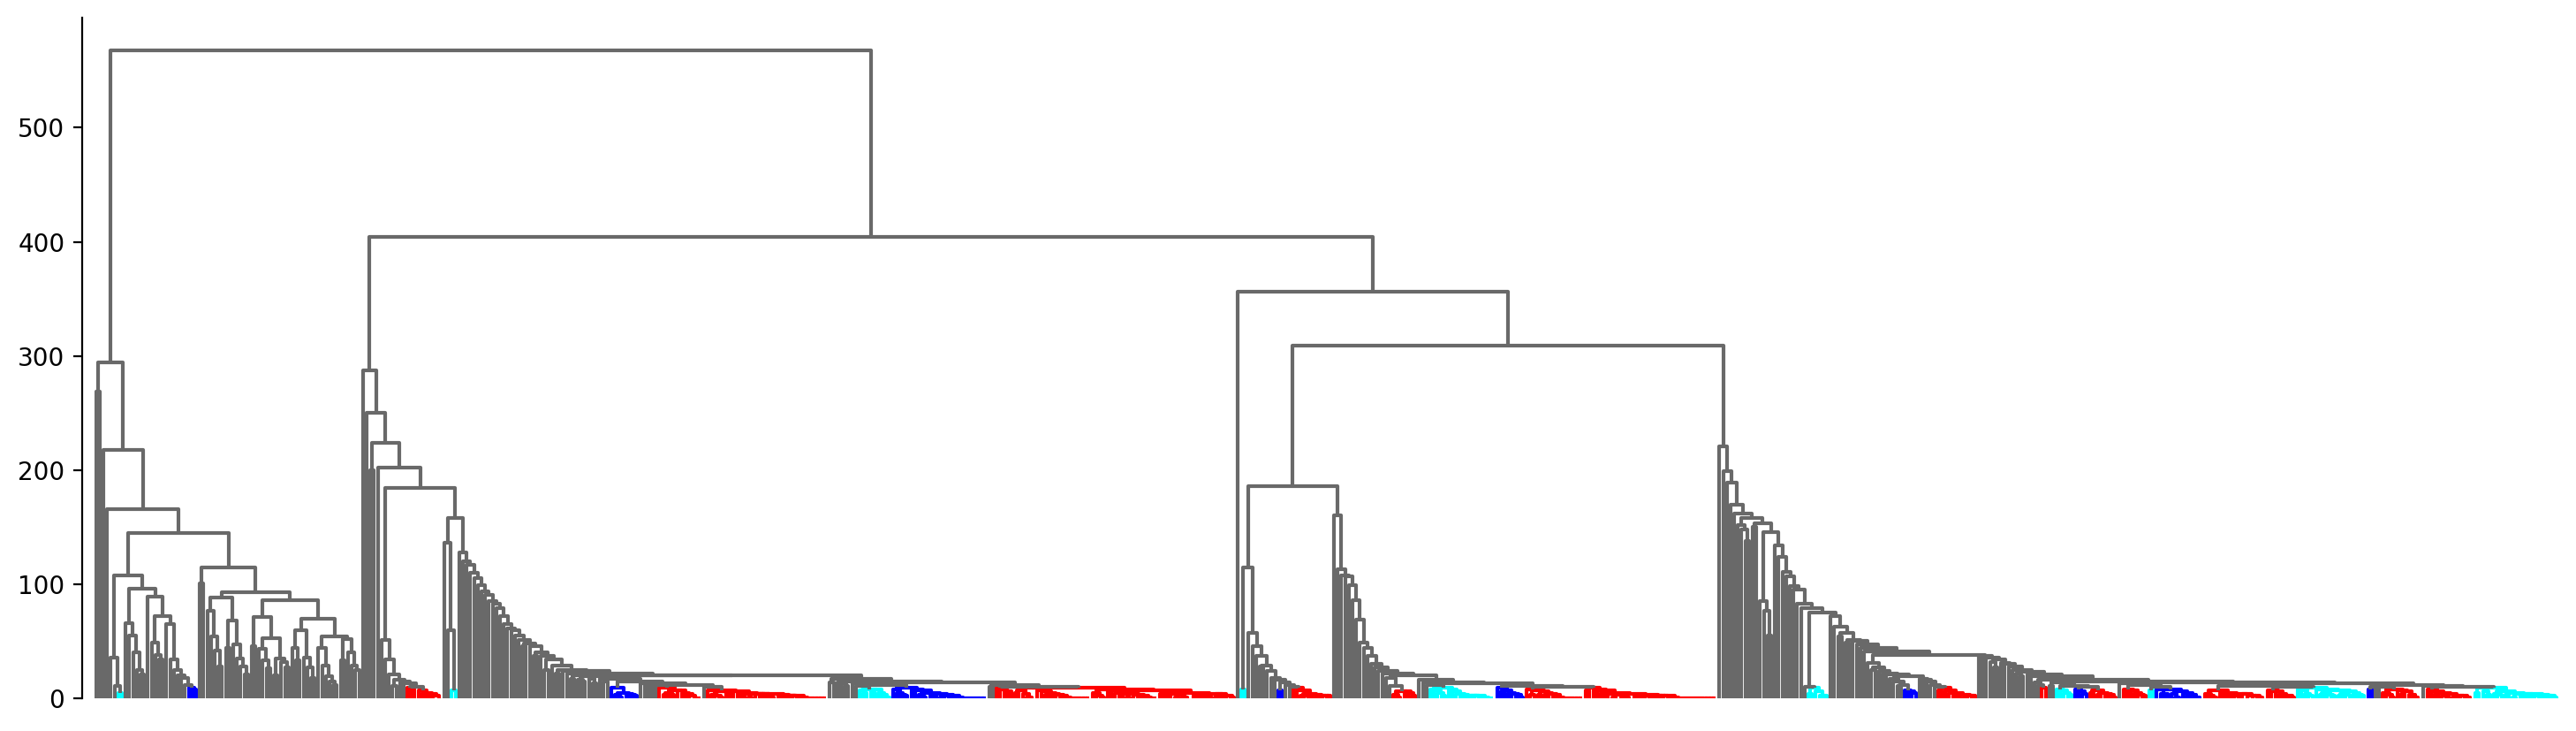

In [11]:
fig, ax = plt.subplots(figsize=(18, 5))
set_link_color_palette(['cyan','blue','red','red'])
sns.despine(ax=ax, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax, color_threshold=10, no_labels=True,
                                          above_threshold_color='dimgrey')

In [12]:
clustard = find_clusters(z, n=10, threshold=12)
vspans = [truspan(cluster, dend) for cluster in clustard]

In [13]:
clusters = find_clusters(z, n=10, threshold=12)

In [14]:
len(clusters)

10

### samples handling, heterozygoty and SNP freq

In [15]:
leaves = dend['leaves']
leaf_data = df_samples.copy().iloc[leaves]
leaf_data['pop_location'] = [z+', '+y for z, y in zip(leaf_data.location, leaf_data.aim_species)]
leaf_list = list(leaf_data['sample_id'])
color_l = dend['leaves_color_list']

leaf_y, n_leaves = 0, len(leaves)
leaf_data['dx'] = np.arange(n_leaves)
leaf_data['dy'] = np.repeat(leaf_y, n_leaves)
leaf_data['dy1'] = np.repeat(0.5, n_leaves)
#leaf_data['dy2'] = np.repeat(leaf_y-0.2, n_leaves)
#leaf_data['dy12'] = np.repeat(-0.01, n_leaves)
pop_ids = list(leaf_data.aim_species.unique())
colored, pop_colors = sns.color_palette("husl", len(pop_ids)), {}
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

In [16]:
het_per_sample = ds_gt.take(leaves).is_het().sum(axis=0) / ds_gt.take(leaves).is_called().sum(axis=0)
df_het = pd.DataFrame({'sample_id': leaf_list, 'heterozigosity': het_per_sample}).set_index('sample_id')
df_het = df_het.loc[leaf_data['sample_id'].to_list(), :].T

In [17]:
df_snps1 = ag3.snp_genotype_allele_counts(transcript=transcript,sample_sets=sets, site_mask='gamb_colu_arab')
df_snps2 = df_snps1.query("effect == ['NON_SYNONYMOUS_CODING', 'START_LOST', 'STOP_LOST', 'STOP_GAINED']")
df_snps3 = df_snps2.set_index('label')
df_snps4 = df_snps3.filter(like='count_').loc[:,['count_'+ s for s in leaf_list]]
df_snps5 = df_snps4.assign(af=lambda x: x.sum(axis=1) / (x.shape[1] * 2))
dfx_snps = df_snps5.drop(columns="af")
#dfs1_snps = df_snps5.query("af > 0.05").drop(columns="af")

#lst_gf = ['2L:2,391,228 G>T (V402L)','2L:2,416,980 C>T (T791M)','2L:2,422,652 A>T (L995F)',
#          '2L:2,422,651 T>C (L995S)','2L:2,429,617 T>C (I1527T)','2L:2,429,896 G>C (E1597Q)',
#          '2L:2,430,880 C>T (P1874S)','2L:2,430,881 C>T (P1874L)']
#dfs_snps = dfx_snps.loc[lst_gf]
#
lst_gf1 = ['2L:2,391,228 G>C (V402L)','2L:2,391,228 G>T (V402L)','2L:2,416,980 C>T (T791M)','2L:2,422,652 A>T (L995F)',
          '2L:2,422,651 T>C (L995S)','2L:2,429,617 T>C (I1527T)','2L:2,429,896 G>C (E1597Q)',
          '2L:2,430,880 C>T (P1874S)','2L:2,430,881 C>T (P1874L)']
dfs_snps = dfx_snps.loc[lst_gf1]

Load SNP genotypes:   0%|          | 0/57 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/209001 [00:00<?, ?it/s]

### Plot clustering

In [18]:
## Costum colors
legend_tips = {'gambiae':["o",0,'turquoise'],'coluzzii':["X",1,'navy'],'arabiensis':["D",2,'violet'],
               'intermediate_gambcolu_arabiensis':['v',3,'darkgoldenrod'],'intermediate_gambiae_coluzzii':['v',3,'darkgoldenrod']}
#legend_tips = {'gambiae':["o",0,'#069AF3'],'coluzzii':["X",1,'#F97306'],'arabiensis':["D",2,'#9A0EEA'],
#               'intermediate_gambcolu_arabiensis':['v',3,'turquoise'],'intermediate_gambiae_coluzzii':['v',3,'turquoise']}
#color1 = {'Agam':'#069AF3','Acol':'#F97306','Aara':'#9A0EEA'}
sp_col = ['turquoise','navy','violet','darkgoldenrod']

ag_dict = {'gambiae':'Agam','coluzzii':'Acol','arabiensis':'Aara',
           'intermediate_gambcolu_arabiensis':'hybrids'}
leg_values = [legend_tips[i][1] for i in leaf_data.aim_species]
leg_labels = ['Agam', 'Acol', 'Aara', 'hybrid']
color_maps = mpl.colors.ListedColormap([legend_tips[i][2] for i in list(legend_tips.keys())[:-1]])
color_maps1 = hap_color = [legend_tips[i][2] for i in leaf_data.aim_species]

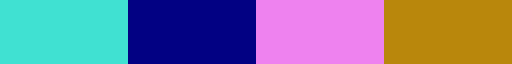

In [19]:
color_maps#, len(color_maps1)

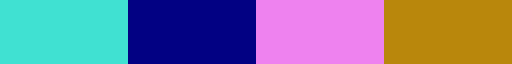

In [20]:
color_maps#, len(color_maps1)

In [21]:
#plt.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
#plt.xlim(0,n_leaves)
#plt.axis('off')

In [22]:
#haplo_maps

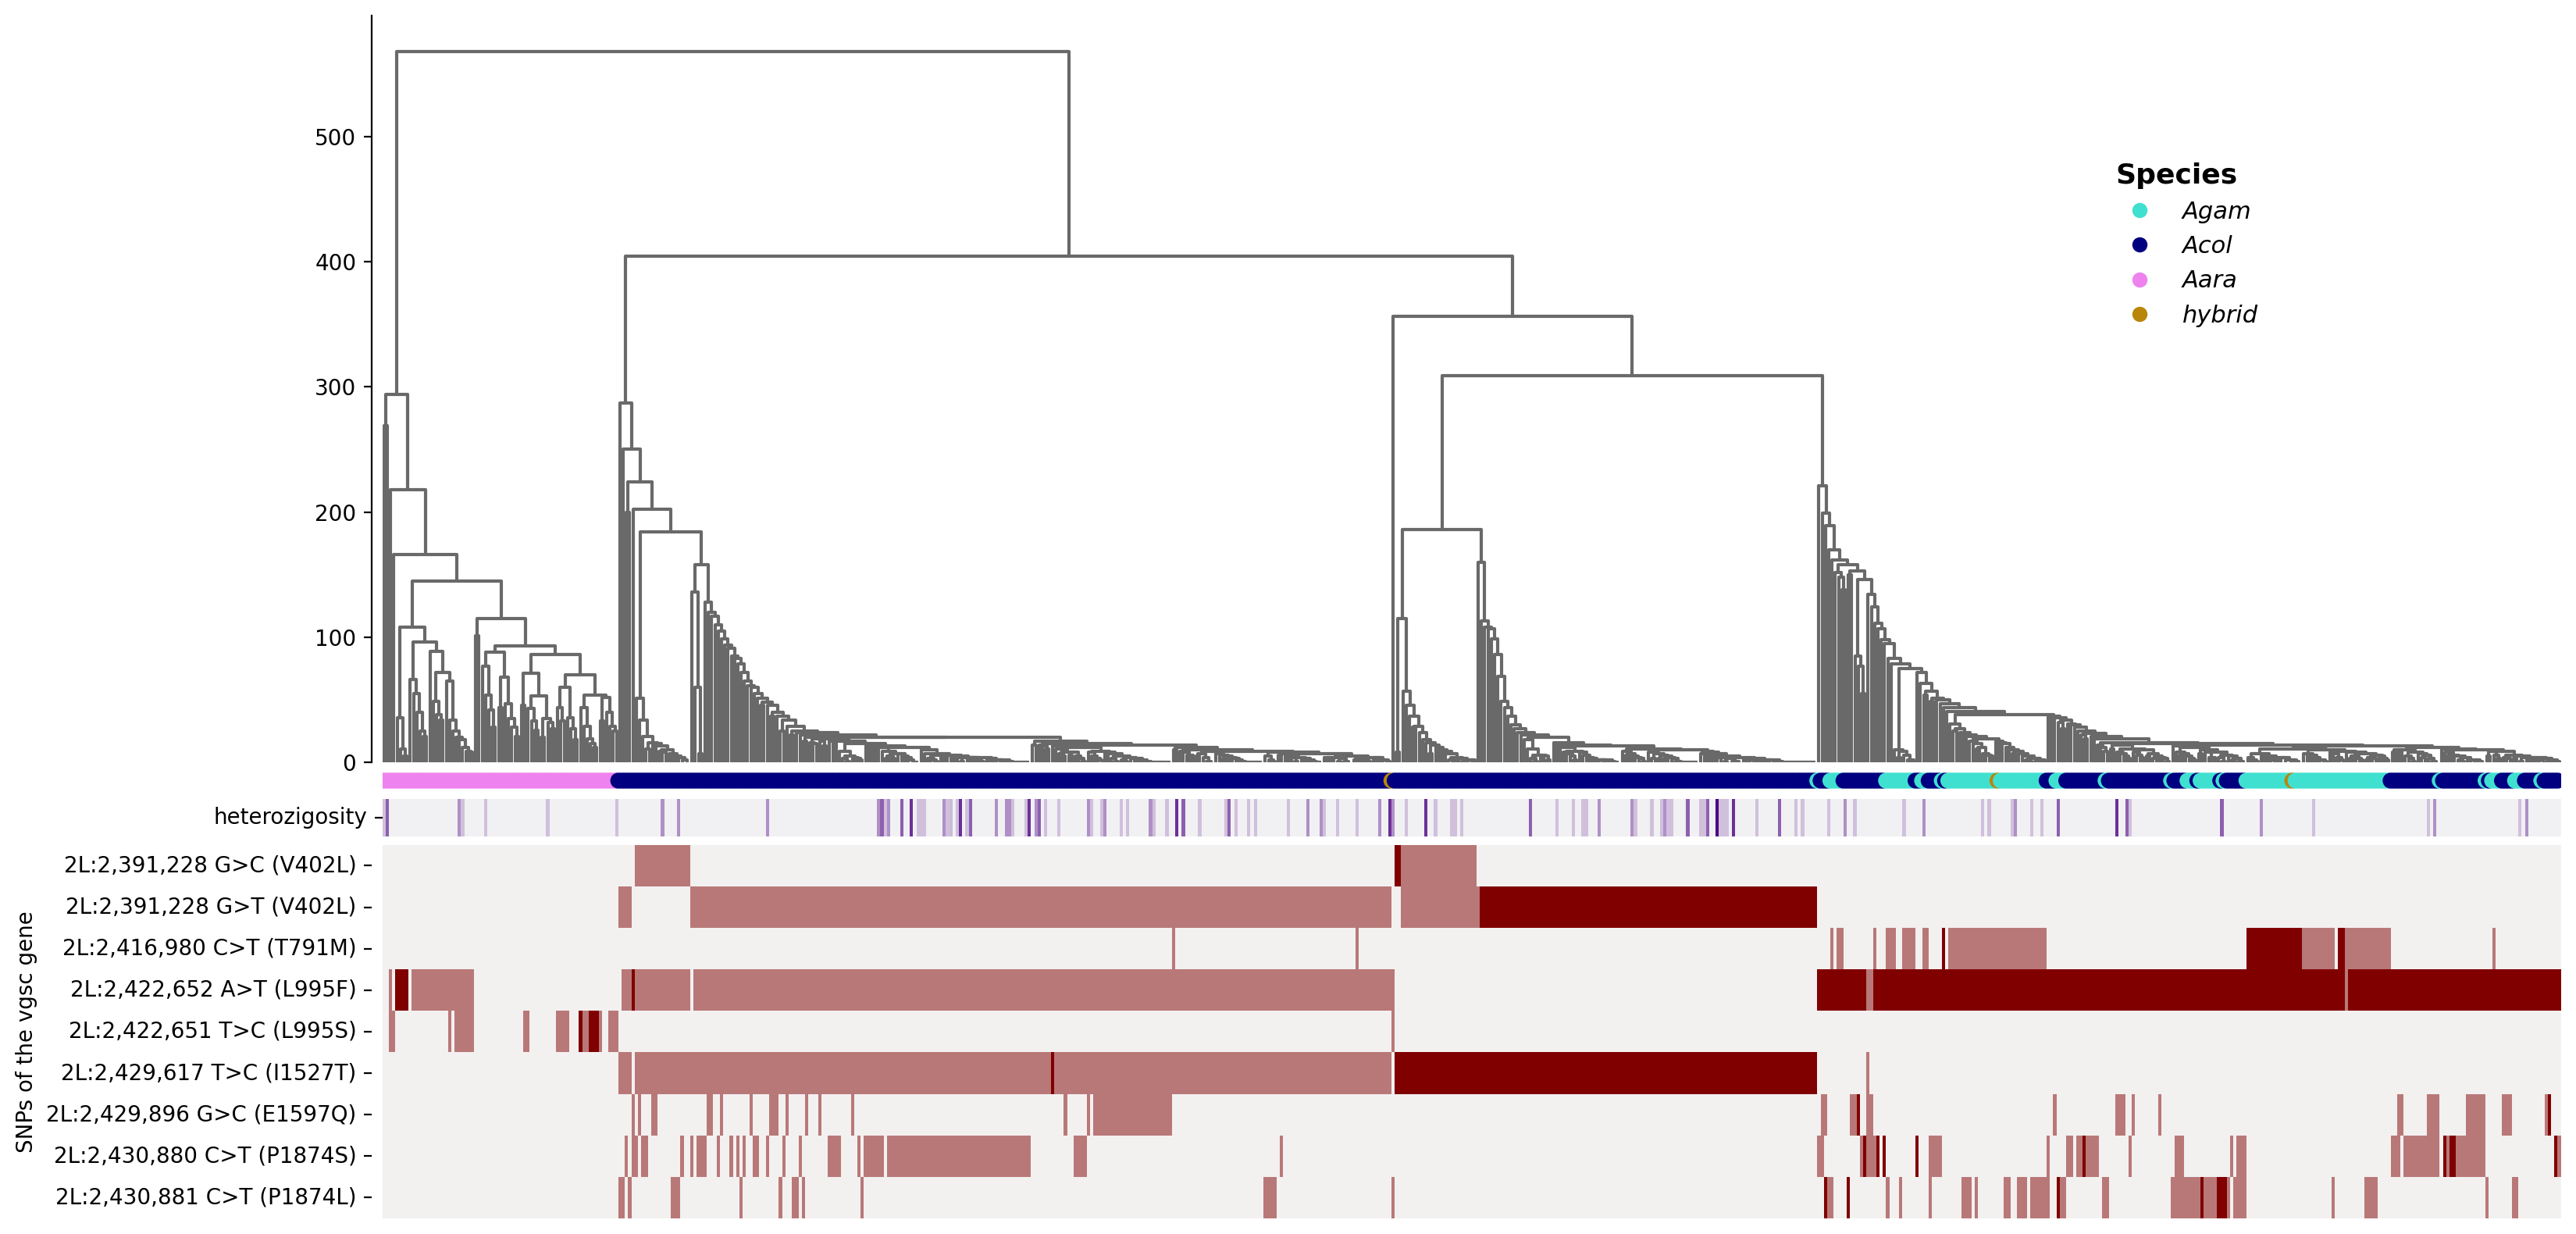

In [23]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                          above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax2=sns.heatmap(data=df_het, cmap=sns.light_palette("indigo", as_cmap=True), xticklabels=[], cbar=False)
ax2.set(xlabel=' ', ylabel=' ')
plt.yticks(rotation=0)

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("maroon", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.8, 0.8),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')


plt.show()
#fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/clust_fig.png',dpi=300, bbox_inches='tight')

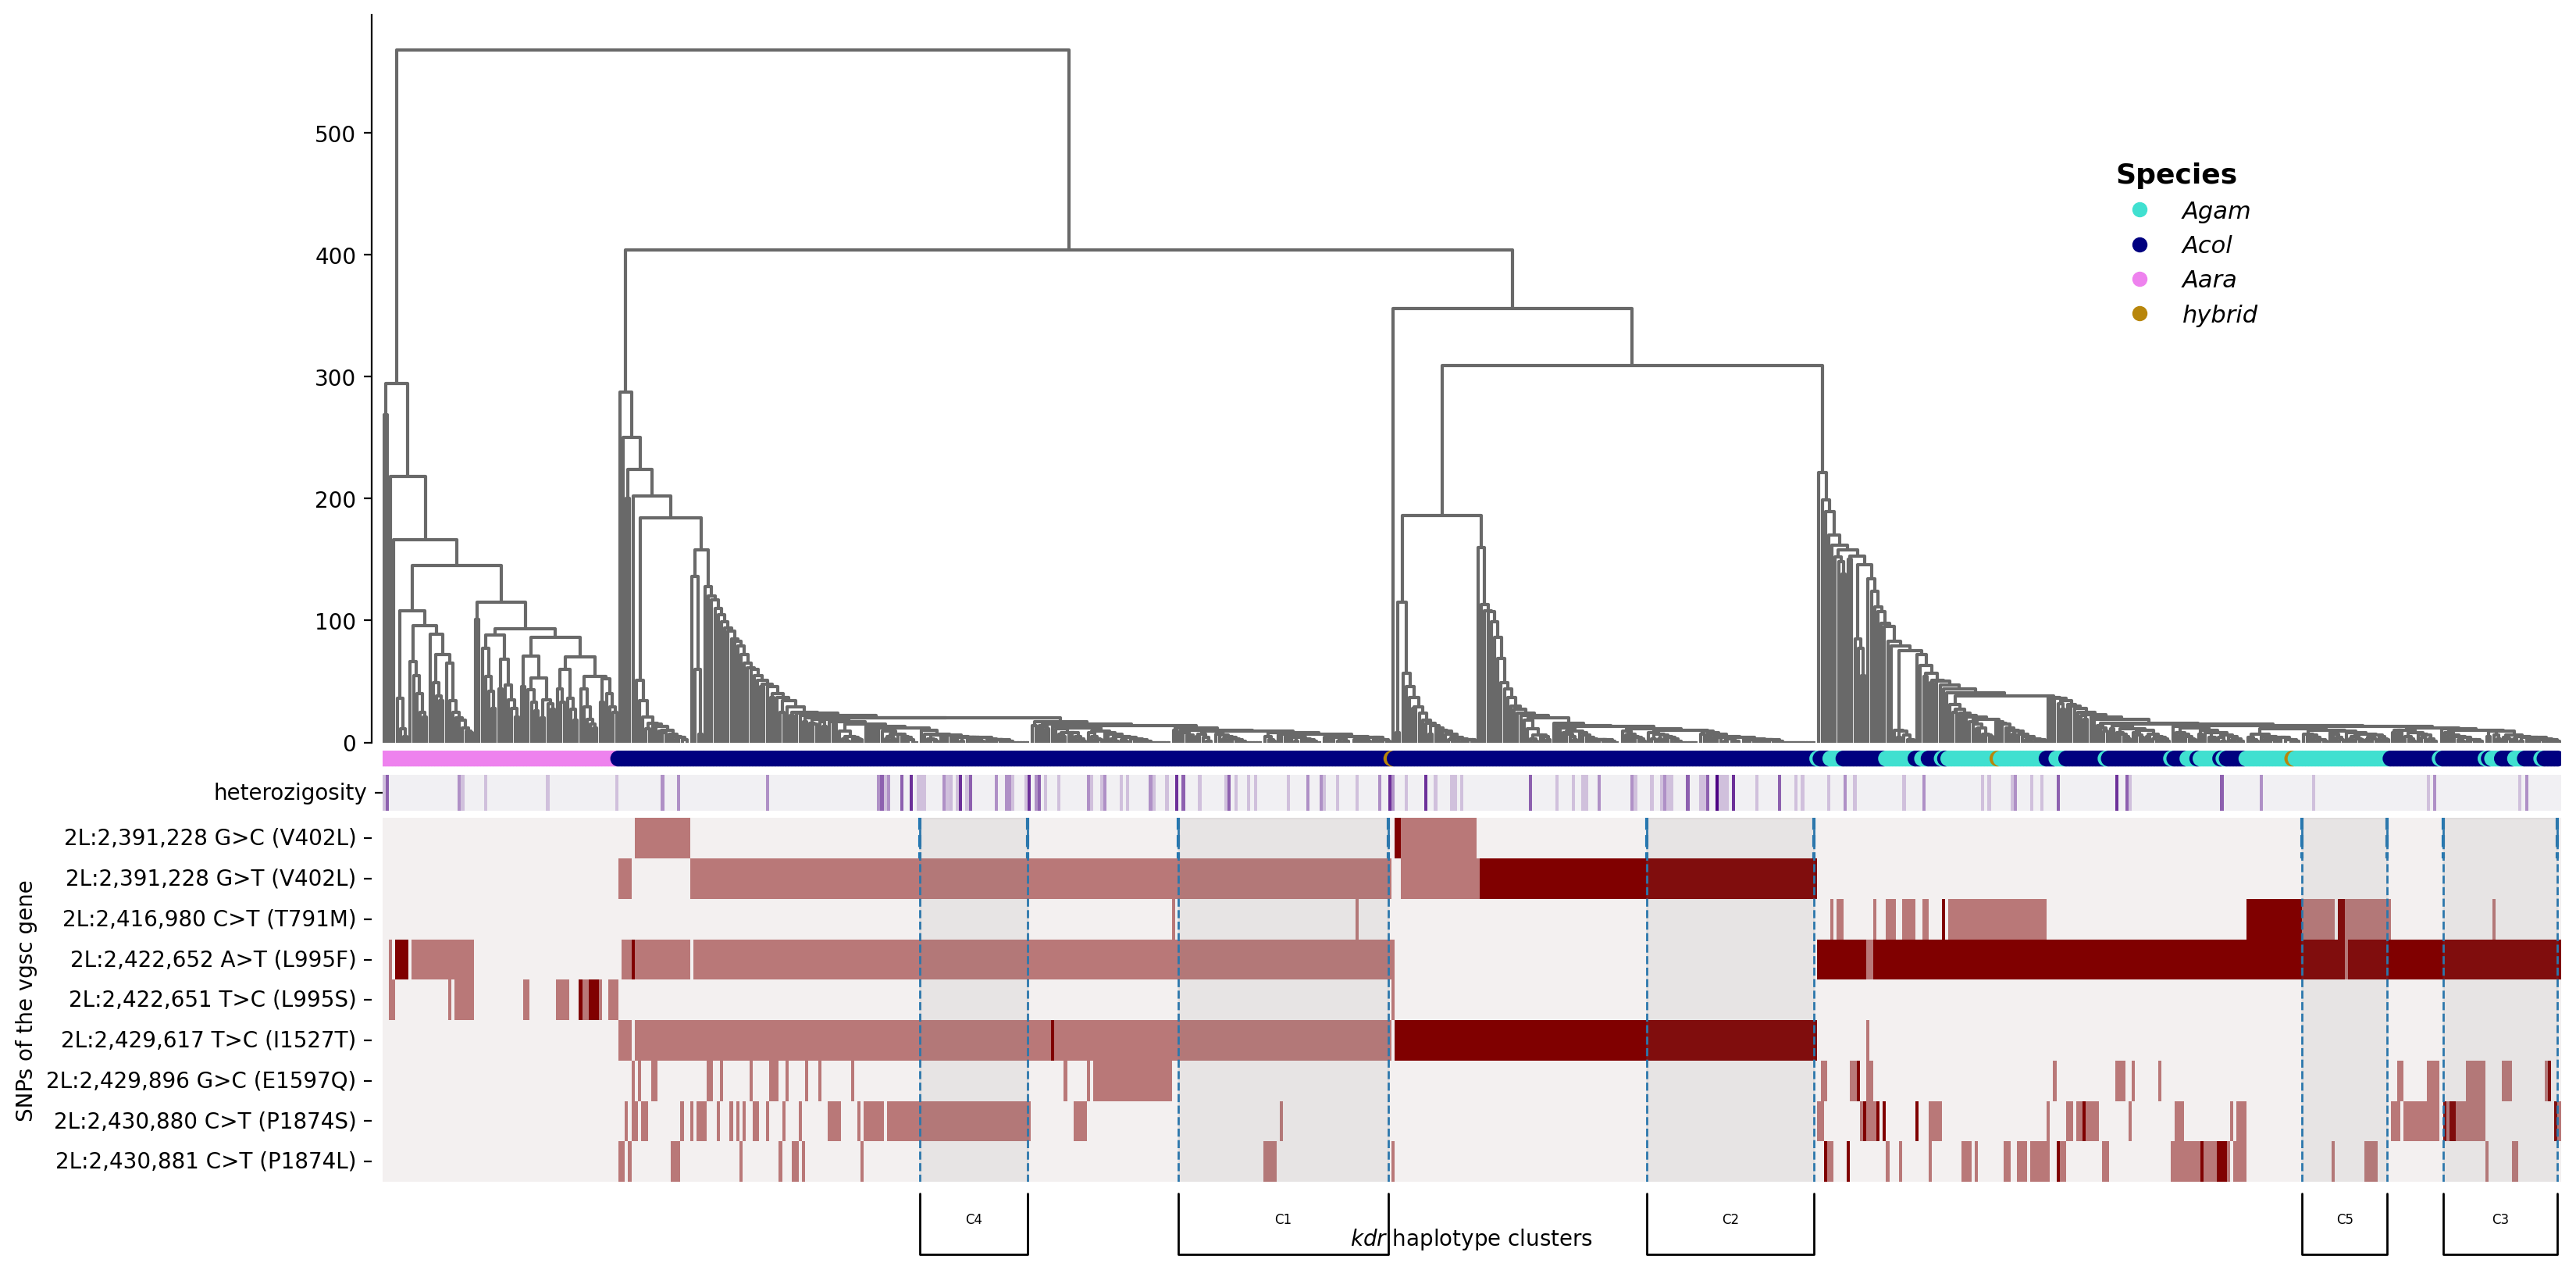

In [24]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(5, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax2=sns.heatmap(data=df_het, cmap=sns.light_palette("indigo", as_cmap=True), xticklabels=[], cbar=False)
ax2.set(xlabel=' ', ylabel=' ')
plt.yticks(rotation=0)

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("maroon", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.8, 0.8),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

clustard = find_clusters(z, n=5, threshold=10)
vspans = [truspan(cluster, dend) for cluster in clustard]
cluster_labels = ['C1', 'C2', 'C3', 'C4', 'C5']
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[4, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, hs.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
    ax3.vlines([xmin, xmax], 0, 1, linestyle='--')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), hs.shape[0],
                                facecolor='gray', edgecolor='gray', alpha=.1,zorder=20))
    ax3.vlines([xmin, xmax], 0, hs.shape[0], linestyle='--', lw=1)
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')

plt.show()
#fig.savefig(fname='VGSC/save_fig/clust_fig.png',dpi=300, bbox_inches='tight')

### Diplotypes samples selection

In [25]:
dfs_snps_T = dfs_snps.T
#dfs_snps_T

In [26]:
#dfs_snps_T

In [27]:
## Haplotypes selections
hom_L995FxL995F = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 2 and `2L:2,391,228 G>T (V402L)` == 0 and `2L:2,429,617 T>C (I1527T)` == 0 and `2L:2,391,228 G>C (V402L)` == 0").index.to_list()
het_L995FxV402LxI1527T = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 1 and `2L:2,391,228 G>T (V402L)` == 1 and `2L:2,429,617 T>C (I1527T)` == 1 and `2L:2,391,228 G>C (V402L)` == 0").index.to_list()
hom_V402LxI1527T = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 0 and `2L:2,391,228 G>T (V402L)` == 2 and `2L:2,429,617 T>C (I1527T)` == 2 and `2L:2,391,228 G>C (V402L)` == 0").index.to_list()
hom_I1527T_het_V402L_het_V402L_GC = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 0 and `2L:2,391,228 G>T (V402L)` == 1 and `2L:2,429,617 T>C (I1527T)` == 2 and `2L:2,391,228 G>C (V402L)` == 1").index.to_list()
het_I1527T_het_L995F_het_V402L_GC = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 1 and `2L:2,391,228 G>T (V402L)` == 0 and `2L:2,429,617 T>C (I1527T)` == 1 and `2L:2,391,228 G>C (V402L)` == 1").index.to_list()
het_I1527T = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 1 and `2L:2,391,228 G>T (V402L)` == 0 and `2L:2,429,617 T>C (I1527T)` >0 and `2L:2,391,228 G>C (V402L)` == 0").index.to_list()
het_V402L = dfs_snps_T.query("`2L:2,391,228 G>T (V402L)` > 0 and `2L:2,429,617 T>C (I1527T)` == 0 and `2L:2,391,228 G>C (V402L)` > 0").index.to_list()

#L995FxV402LxI1527T_htz = list_I1527T_htz1 + list_I1527T_htz2 + list_I1527T_htz1 + list_I1527T_htz2
#VLI = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 0 and `2L:2,391,228 G>T (V402L)` == 0 and `2L:2,429,617 T>C (I1527T)` == 0").index.to_list()
dip_var_sel = hom_L995FxL995F+het_L995FxV402LxI1527T+hom_V402LxI1527T+hom_I1527T_het_V402L_het_V402L_GC+het_I1527T_het_L995F_het_V402L_GC
OD = [i for i in dfs_snps_T.index.to_list() if i not in dip_var_sel]

haplo = {
    'FVI/FVI': hom_L995FxL995F,
    'FL1T/LVI': het_L995FxV402LxI1527T,
    'LL1T/LL1T': hom_V402LxI1527T,
    'LL1T/LL2T':hom_I1527T_het_V402L_het_V402L_GC,
    'FL2T/LVI':het_I1527T_het_L995F_het_V402L_GC,
    #'VLI/VLI': VLI,
    'OD': OD
}

haplo_sample_id = {
    'FVI/FVI': [i.split('count_')[1] for i in hom_L995FxL995F],
    'FL1T/LVI': [i.split('count_')[1] for i in het_L995FxV402LxI1527T],
    'LL1T/LL1T': [i.split('count_')[1] for i in hom_V402LxI1527T],
    'LL1T/LL2T':[i.split('count_')[1] for i in hom_I1527T_het_V402L_het_V402L_GC],
    'FL2T/LVI':[i.split('count_')[1] for i in het_I1527T_het_L995F_het_V402L_GC],
    #'VLI/VLI': [i.split('count_')[1] for i in VLI],
    'OD': [i.split('count_')[1] for i in OD]
}

In [28]:
LT = [i.split('count_')[1] for i in het_I1527T]
LL = [i.split('count_')[1] for i in het_V402L]
print(len(LT), len(LL)) ## one individual mosquito where 1527T is fully unkinked to the 402L;
df_samples.query(f'sample_id=={LT}')#.columns # An. coluzzii from Souroukoudingan

1 0


,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,...,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter
176,VBS93244-7551STDY14567897,BF.SK.22.229.10,Abdoulaye Diabate,Burkina Faso,Souroukoudinga,2022,7,11.235,-4.535,F,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2022,BF-09_colu_2022_07,BF-09_colu_2022_Q3,BF-09_Houet_colu_2022,BF-09_Houet_colu_2022_07,BF-09_Houet_colu_2022_Q3


In [29]:
for key in haplo_sample_id.keys():
  print(key, len(haplo_sample_id[key]))

FVI/FVI 229
FL1T/LVI 215
LL1T/LL1T 103
LL1T/LL2T 23
FL2T/LVI 17
OD 78


In [30]:
L995F_haplo0 = dfs_snps.loc[:,dfs_snps.loc['2L:2,422,652 A>T (L995F)',:]==0]
L995F_hap0_samples = [i.split('count_')[1] for i in L995F_haplo0.columns.to_list()]
L995F_haplo1 = dfs_snps.loc[:,dfs_snps.loc['2L:2,422,652 A>T (L995F)',:]==1]
L995F_hap1_samples = [i.split('count_')[1] for i in L995F_haplo1.columns.to_list()]
L995F_haplo2 = dfs_snps.loc[:,dfs_snps.loc['2L:2,422,652 A>T (L995F)',:]==2]
L995F_hap2_samples = [i.split('count_')[1] for i in L995F_haplo2.columns.to_list()]

In [31]:
haplo_dict = {'L995F_hap0_samples':L995F_hap0_samples,
              'L995F_hap1_samples':L995F_hap1_samples,
              'L995F_hap2_samples':L995F_hap2_samples}

In [32]:
haplo_dict.keys()
np.save('drive/MyDrive/sanger_analyses/resistance/VGSC/data/haplo_dict_all.npy', haplo_dict)
np.save('drive/MyDrive/sanger_analyses/resistance/VGSC/data/haplo_sample_id_all.npy', haplo_sample_id)

# Compute PCA

In [33]:
map_dict = {}
for hap in haplo_sample_id.keys():
  hap_i = haplo_sample_id[hap]
  for sample_id in hap_i:
    map_dict[sample_id] = hap
len(map_dict.keys())
df_samples['haplo_id'] = df_samples.sample_id.map(map_dict)

hap_labels = {
    'FVI/FVI': '995F+402V+1527I//995F+402V+1527I',
    'FL1T/LVI': '995F+402L(g>t)+1527T//995L+402V+1527I',
    'LL1T/LL1T':'995L+402L(g>t)+1527T//995L+402L(g>t)+1527T',
    'LL1T/LL2T': '995L+402L(g>t)+1527T//995L+402L(g>c)+1527T',
    'FL2T/LVI': '995F+402L(g>c)+1527T//995L+402V+1527I',
    'OD': 'Other diplotypes'
}

haplo_source = list(haplo_sample_id.keys())
haplo_col = sns.color_palette(n_colors=len(hap_labels.keys()))
leaf_data['haplo_id'] = leaf_data.sample_id.map(map_dict)
leaf_data['haplo_label'] = leaf_data.haplo_id.map(hap_labels)

haplo_tips = {
    '995F+402V+1527I//995F+402V+1527I':["D",0,haplo_col[0]],
    '995F+402L(g>t)+1527T//995L+402V+1527I':["D",1,haplo_col[1]],
    '995L+402L(g>t)+1527T//995L+402L(g>t)+1527T':["D",2,haplo_col[2]],
    '995L+402L(g>t)+1527T//995L+402L(g>c)+1527T':["D",3,haplo_col[3]],
    '995F+402L(g>c)+1527T//995L+402V+1527I':["D",4,haplo_col[4]],
    'Other diplotypes':["D",5,haplo_col[5]]
}

haplo_values = [haplo_tips[i][1] for i in leaf_data.haplo_label]
haplo_labels = ['995F+402V+1527I//995F+402V+1527I', '995F+402L(g>t)+1527T//995L+402V+1527I',
                '995L+402L(g>t)+1527T//995L+402L(g>t)+1527T','995L+402L(g>t)+1527T//995L+402L(g>c)+1527T',
                '995F+402L(g>c)+1527T//995L+402V+1527I','Other diplotypes']

hap_color = [haplo_tips[i][2] for i in leaf_data.haplo_label]
haplo_maps = mpl.colors.ListedColormap([haplo_tips[i][2] for i in list(haplo_tips.keys())[:-1]])

## Create cluster groups based on diplotypes indexes
results,current_grp, interval,indexes, hapidx = [], [], [], [], []
for idx,vals in enumerate(haplo_values):
  if not current_grp or current_grp[-1] == vals:
    current_grp.append(vals)
    indexes.append(idx)
    hapidx.append(leaves_list(z)[idx])
  else:
    results.append(hapidx)
    interval.append((indexes[0],indexes[-1]))
    current_grp = [vals]
    indexes = [idx]
    hapidx = [leaves_list(z)[idx]]
if current_grp:
  results.append(hapidx)
  interval.append((indexes[0],indexes[-1]))

#select vspans
vspans = []
for i in results:
  if len(i) > 10:
    vspans.append(interval[results.index(i)])
#vspans

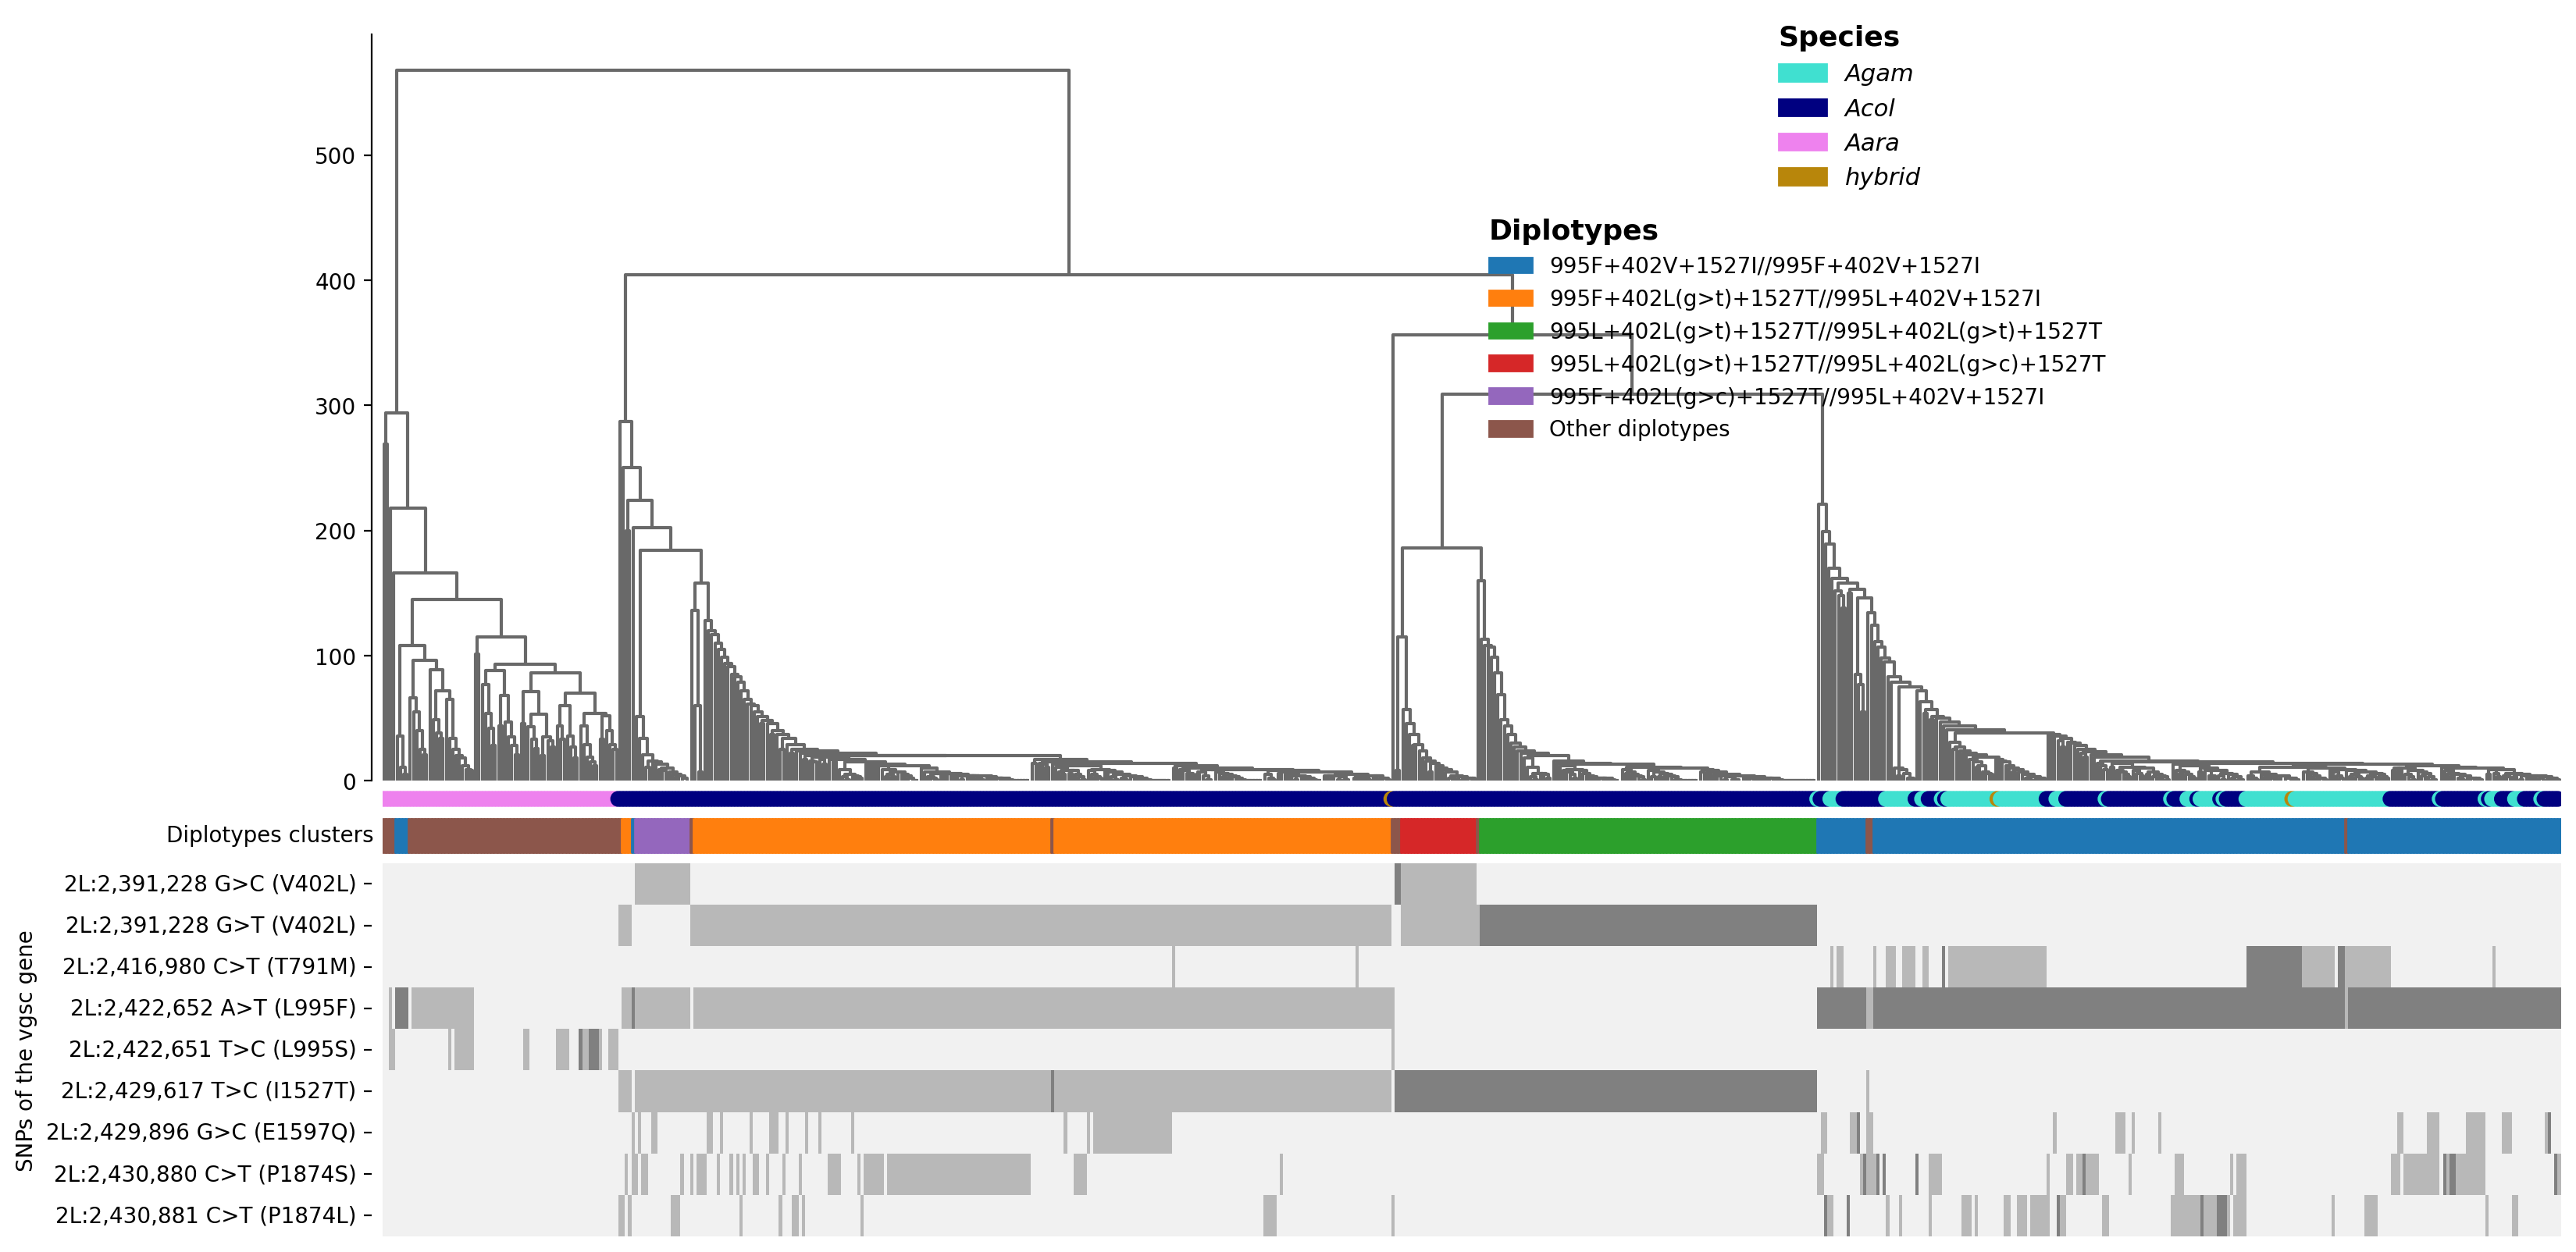

In [34]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Diplotypes clusters',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

sf = list(ag_dict.keys())
ccmap = dict(zip(sf, sp_col))
handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',
              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.8, 0.78),frameon=False)
ax0.add_artist(aleg)

plt.show()
#fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/clust_fig1.png',dpi=300, bbox_inches='tight')

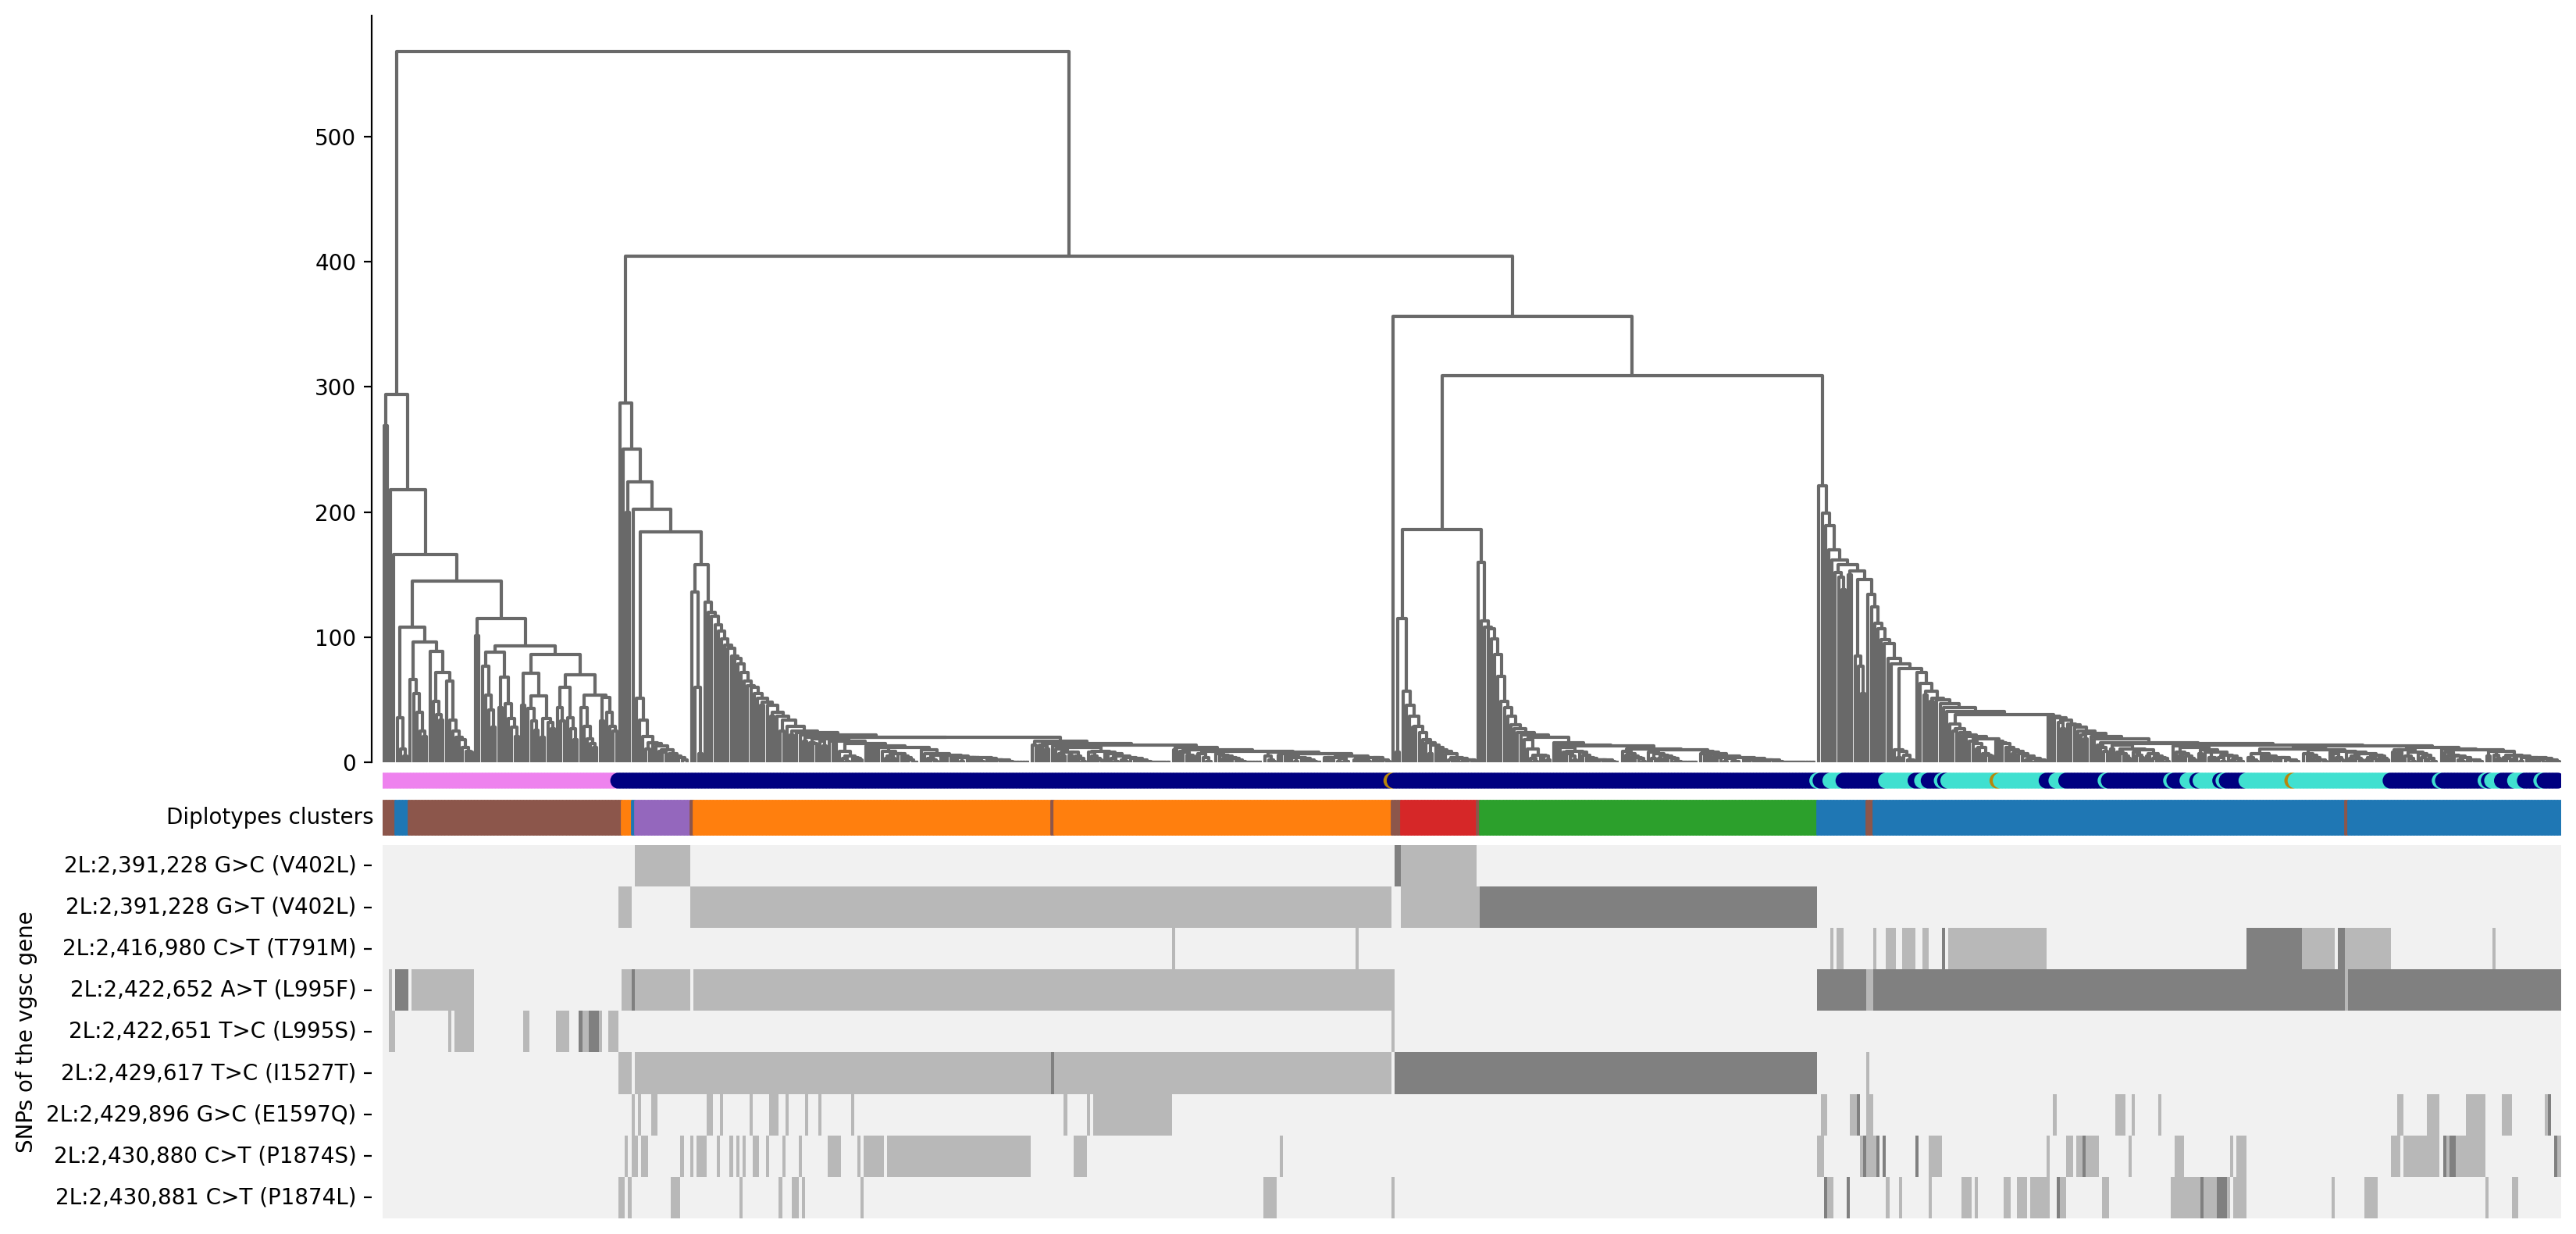

In [35]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Diplotypes clusters',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

#sf = list(ag_dict.keys())
#ccmap = dict(zip(sf, sp_col))
#handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
#fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
#          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
#handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
#aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',
#              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.8, 0.78),frameon=False)
#ax0.add_artist(aleg)

plt.show()
fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/clust_fig12.png',dpi=300, bbox_inches='tight')

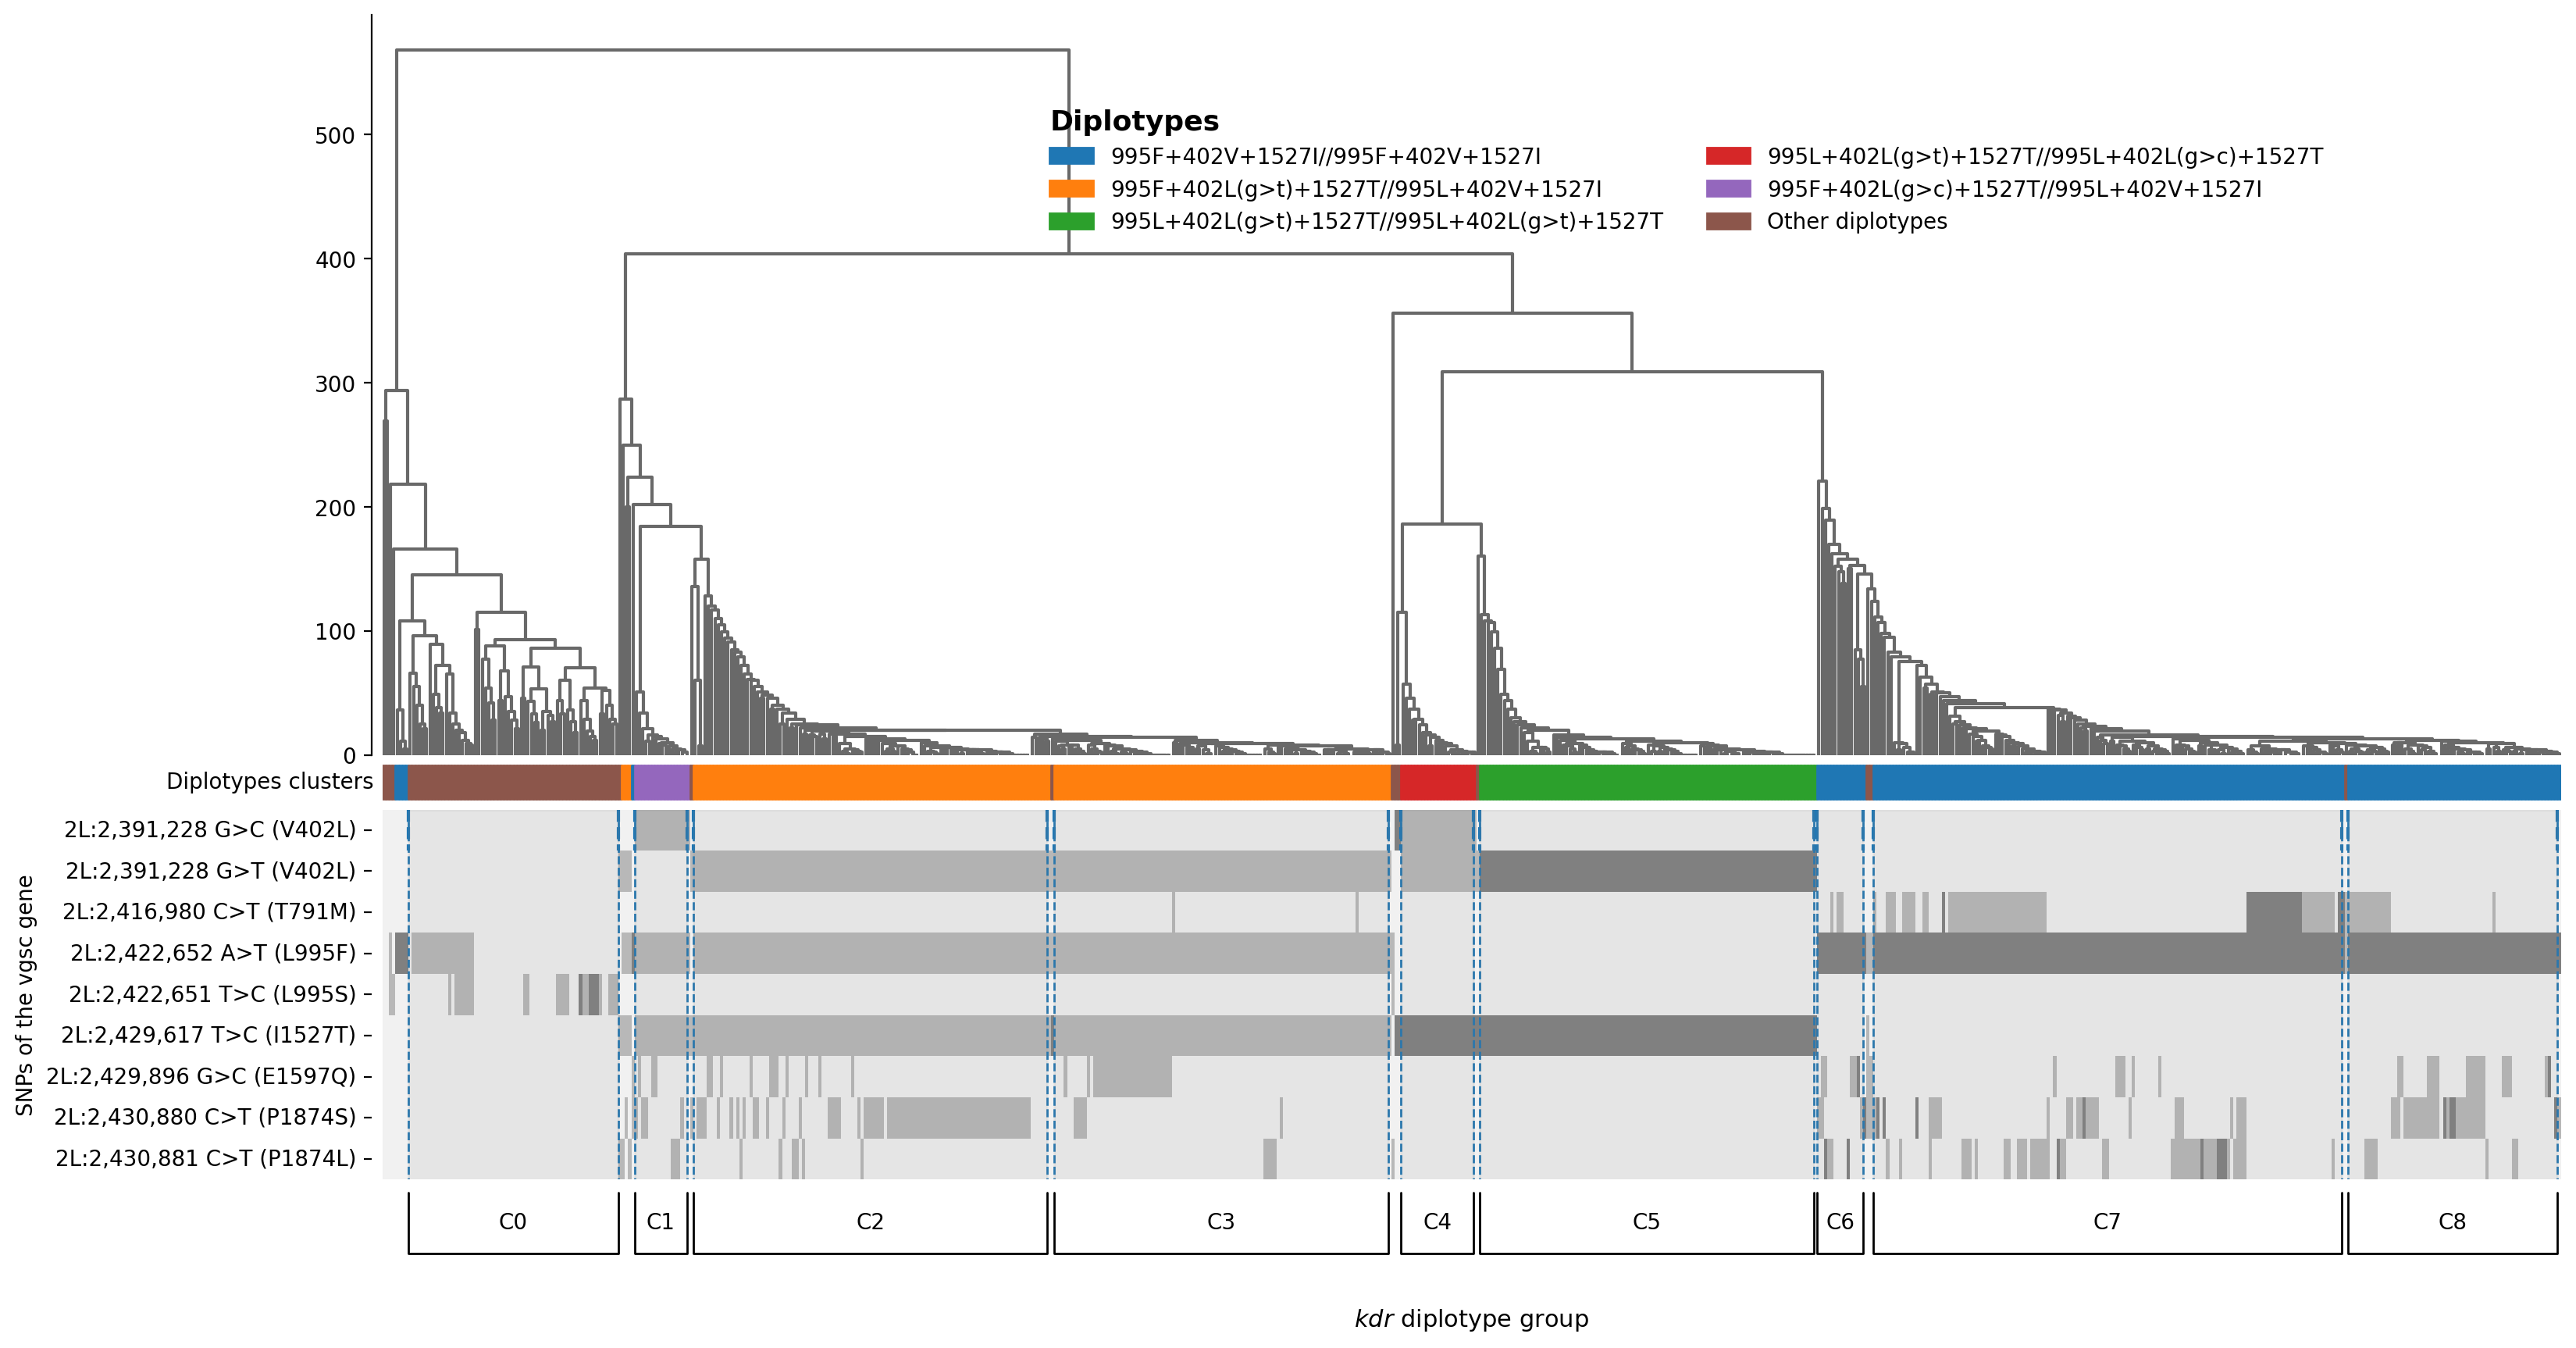

In [36]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
#ax1 = plt.subplot(gs[1, 0])
#ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
##plt.xlim(0,n_leaves)
#plt.axis('off')

ax2 = plt.subplot(gs[1, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Diplotypes clusters',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[2, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
cluster_labels = [f'C{i}' for i in range(len(vspans))]
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[3, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=10)
    ax3.vlines([xmin, xmax], 0, 1, linestyle='--')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.1,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1)
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
ax_clu.text(df_het.shape[1]/2, -3, '$kdr$ diplotype group', va='top', ha='center', fontsize=11)
    #ax_clu.set_xlabel('$kdr$ diplotype group')


#sf = list(ag_dict.keys())
#ccmap = dict(zip(sf, sp_col))
#handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
#fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
#          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',ncol=2,
              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.9, 0.9),frameon=False)
ax0.add_artist(aleg)

plt.show()
fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/clust_fig12_all.png',dpi=300, bbox_inches='tight')

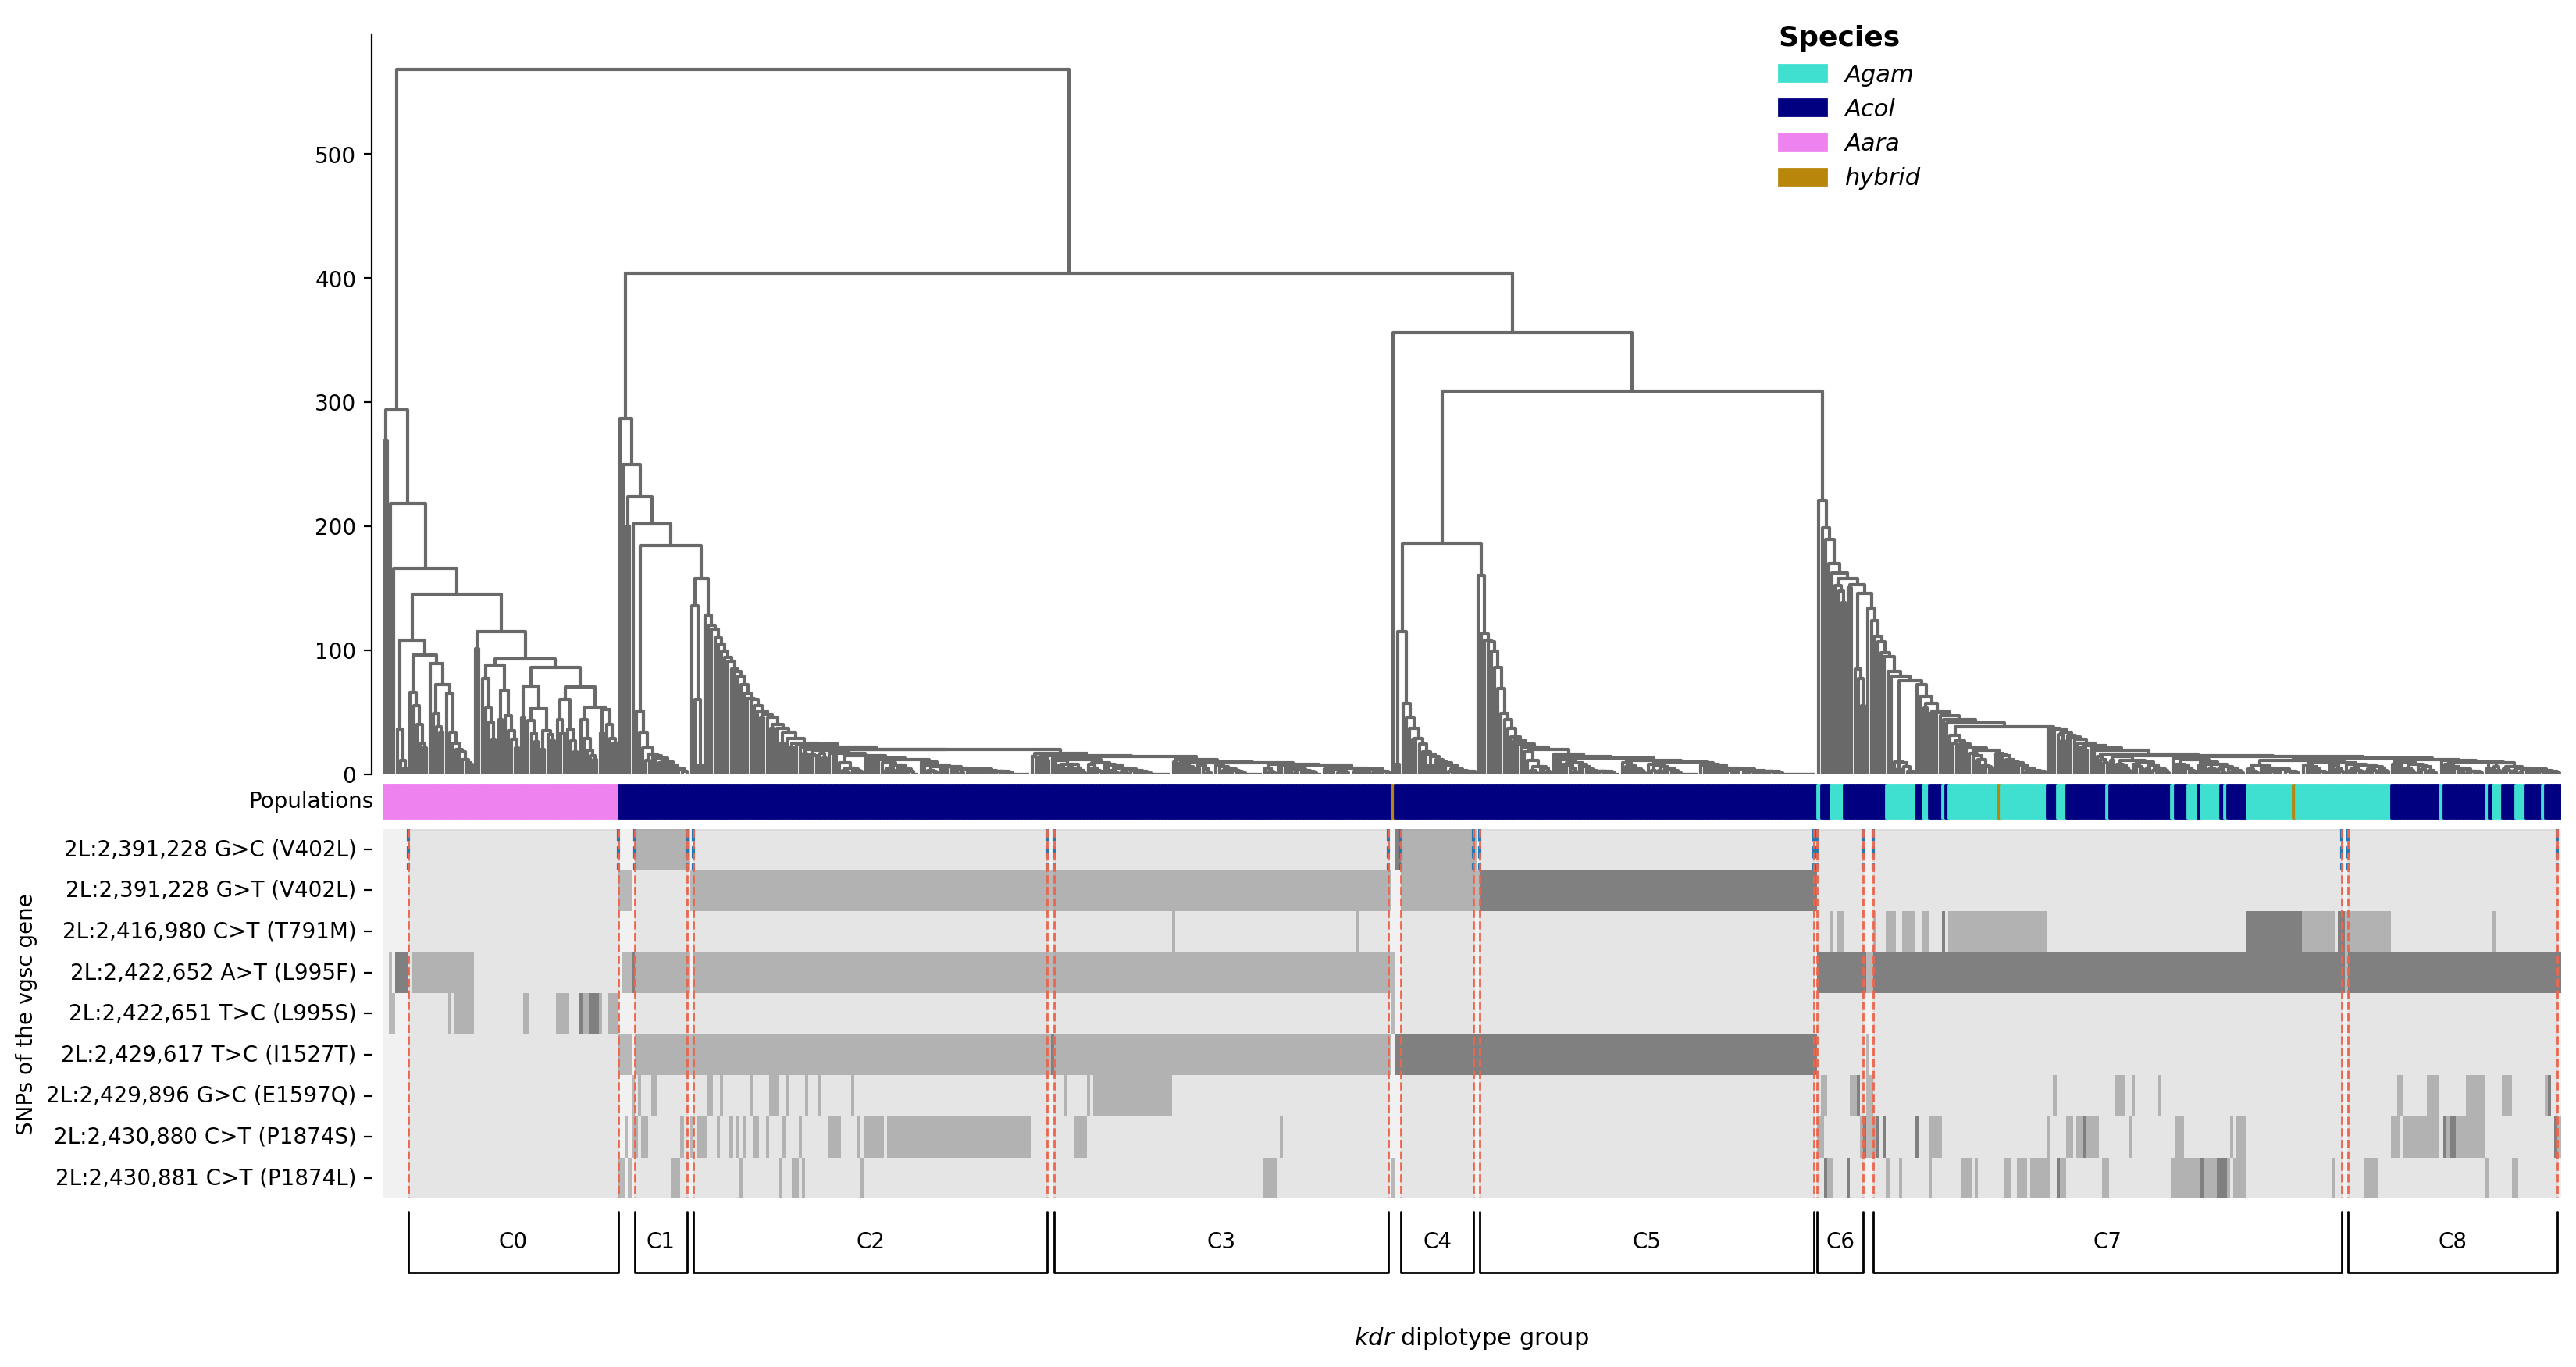

In [37]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
#ax1 = plt.subplot(gs[1, 0])
#ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
##plt.xlim(0,n_leaves)
#plt.axis('off')

ax2 = plt.subplot(gs[1, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=color_maps1)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Populations',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[2, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
#cluster_labels = ['FT/LI', 'LT/VT', 'LT/LT', 'FF/FF', 'FLT/LVI','FLT/LVI']
cluster_labels = [f'C{i}' for i in range(len(vspans))]
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[3, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=10)
    ax3.vlines([xmin, xmax], 0, 1, linestyle='--')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.1,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1, colors='tomato')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
ax_clu.text(df_het.shape[1]/2, -3, '$kdr$ diplotype group', va='top', ha='center', fontsize=11)
    #ax_clu.set_xlabel('$kdr$ diplotype group')


sf = list(ag_dict.keys())
ccmap = dict(zip(sf, sp_col))
handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
#handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
#aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',ncol=2,
#              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.9, 0.9),frameon=False)
#ax0.add_artist(aleg)

plt.show()
#fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/clust_fig12_all.png',dpi=300, bbox_inches='tight')

In [38]:
## group the same clusters
vspans_mod = [(8, 72),(77, 93),(95, 307), (311, 334),(335, 437),(438,664)]

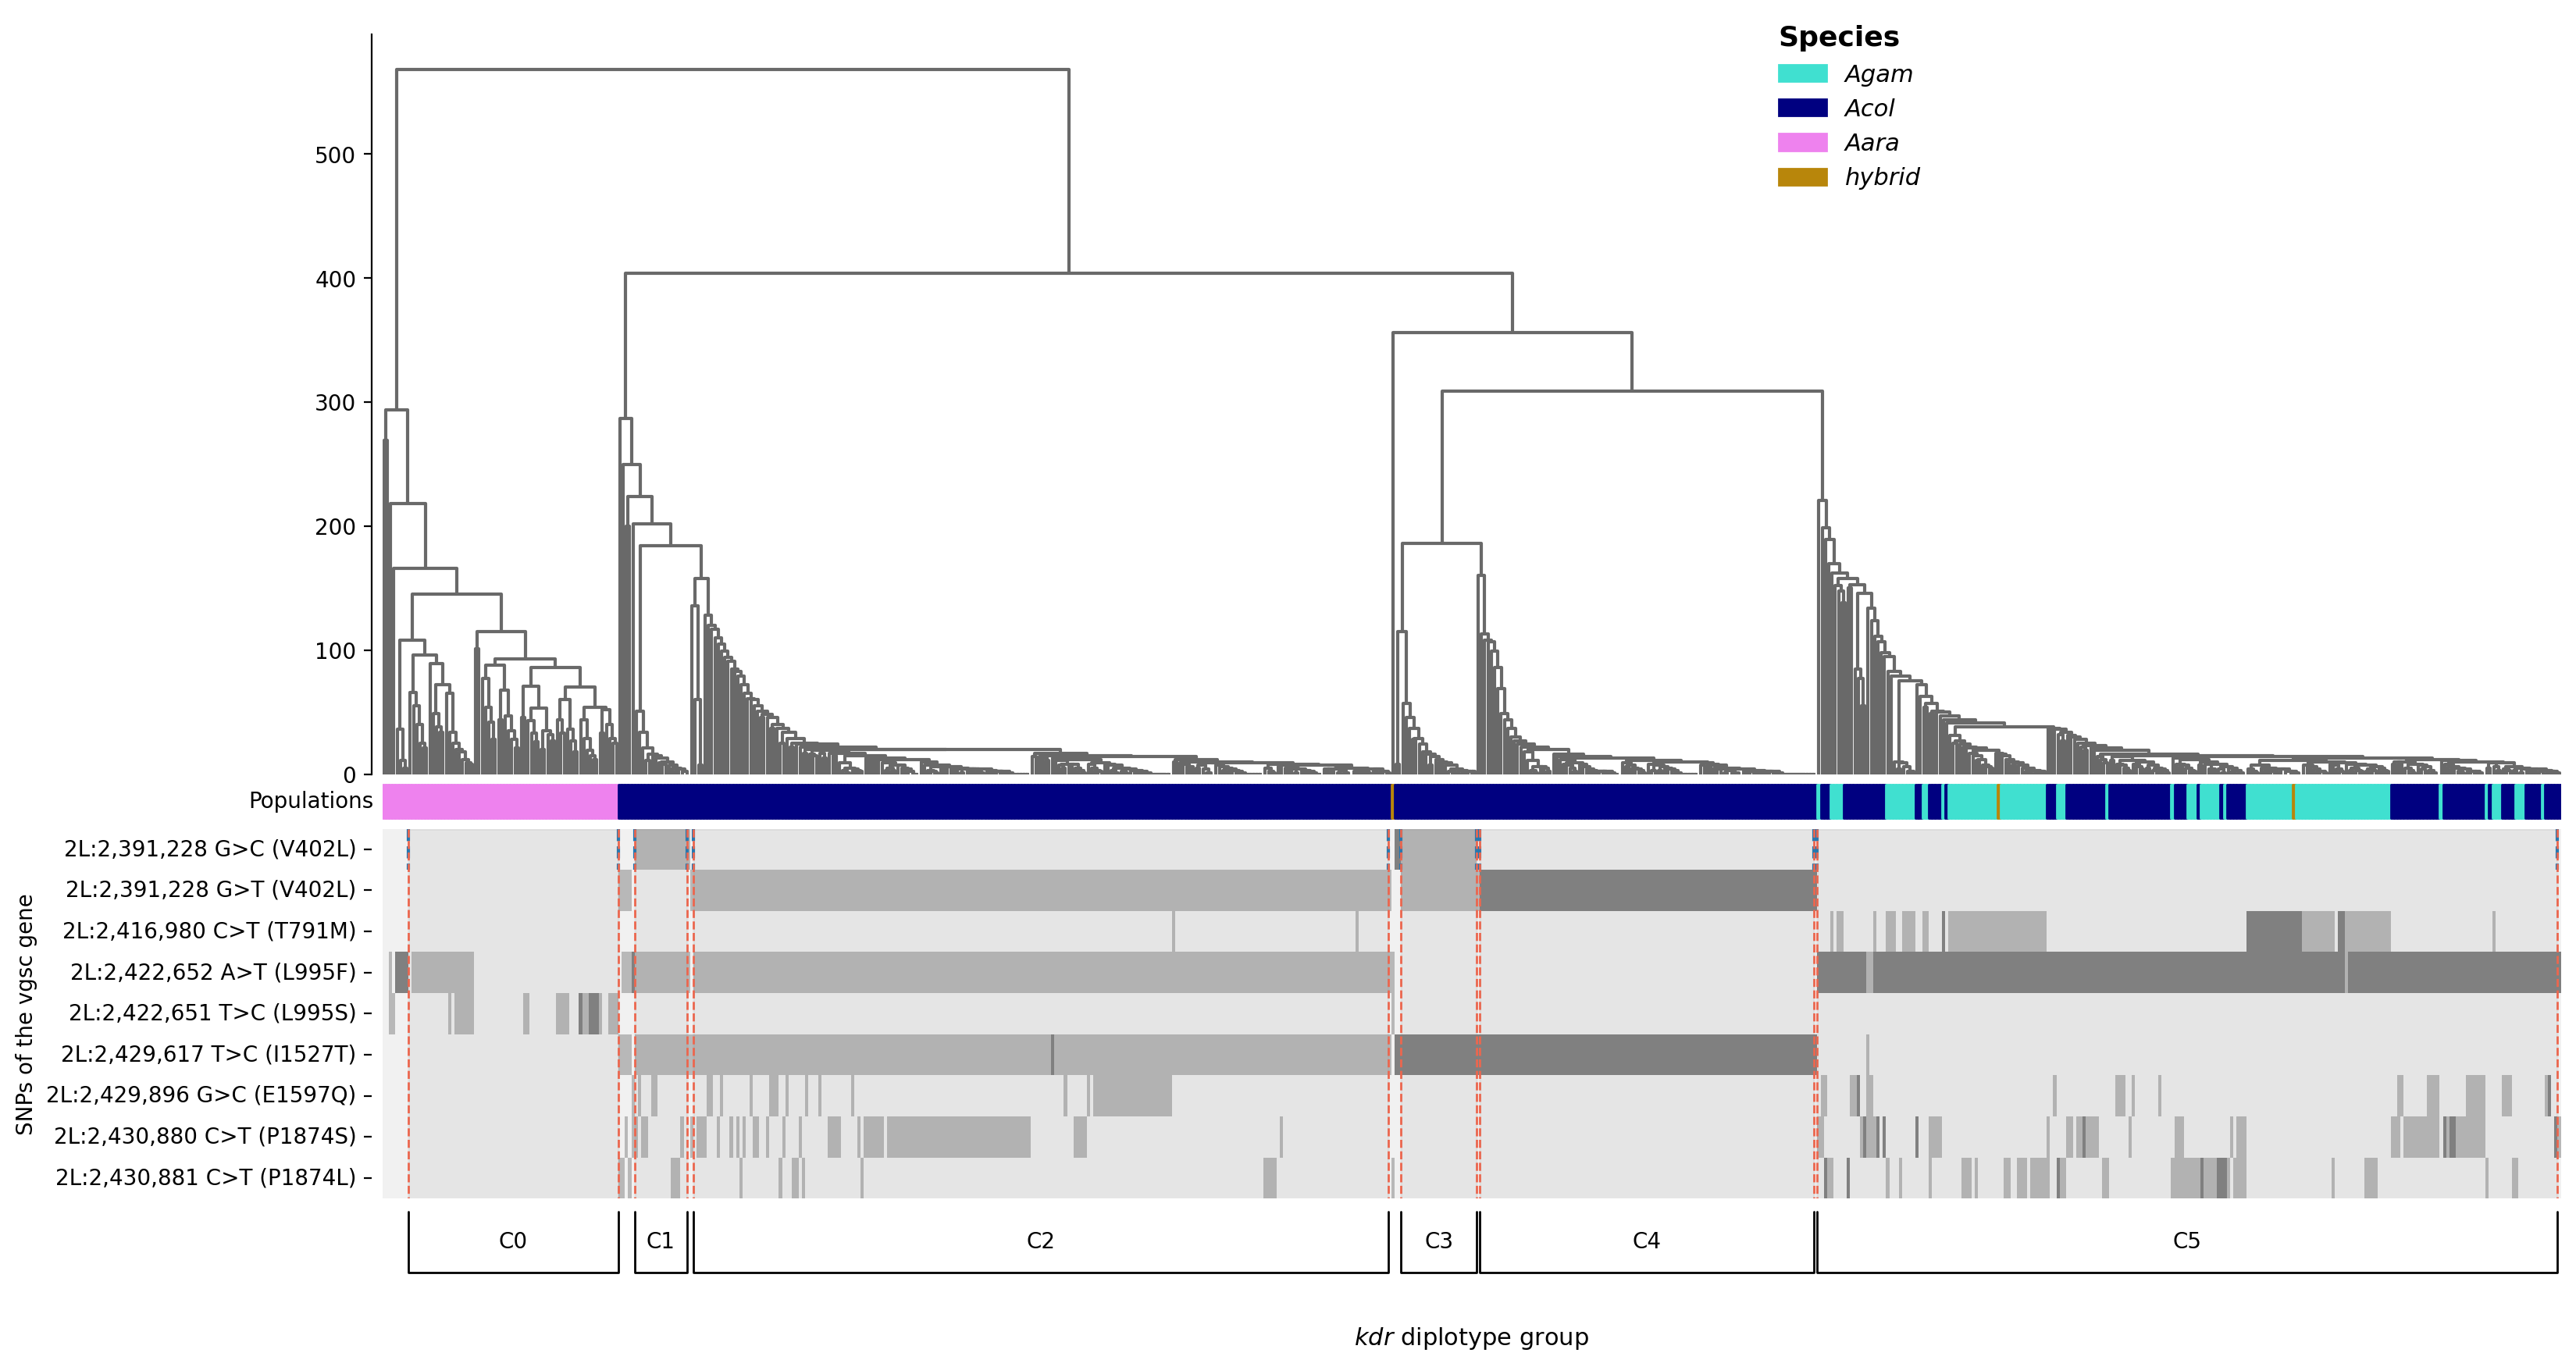

In [39]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
#ax1 = plt.subplot(gs[1, 0])
#ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
##plt.xlim(0,n_leaves)
#plt.axis('off')

ax2 = plt.subplot(gs[1, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=color_maps1)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Populations',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[2, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
#cluster_labels = ['FT/LI', 'LT/VT', 'LT/LT', 'FF/FF', 'FLT/LVI','FLT/LVI']
cluster_labels = [f'C{i}' for i in range(len(vspans_mod))]
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[3, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans_mod):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=10)
    ax3.vlines([xmin, xmax], 0, 1, linestyle='--')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.1,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1, colors='tomato')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
ax_clu.text(df_het.shape[1]/2, -3, '$kdr$ diplotype group', va='top', ha='center', fontsize=11)
    #ax_clu.set_xlabel('$kdr$ diplotype group')


sf = list(ag_dict.keys())
ccmap = dict(zip(sf, sp_col))
handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
#handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
#aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',ncol=2,
#              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.9, 0.9),frameon=False)
#ax0.add_artist(aleg)

plt.show()
#fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/clust_fig12_all.png',dpi=300, bbox_inches='tight')

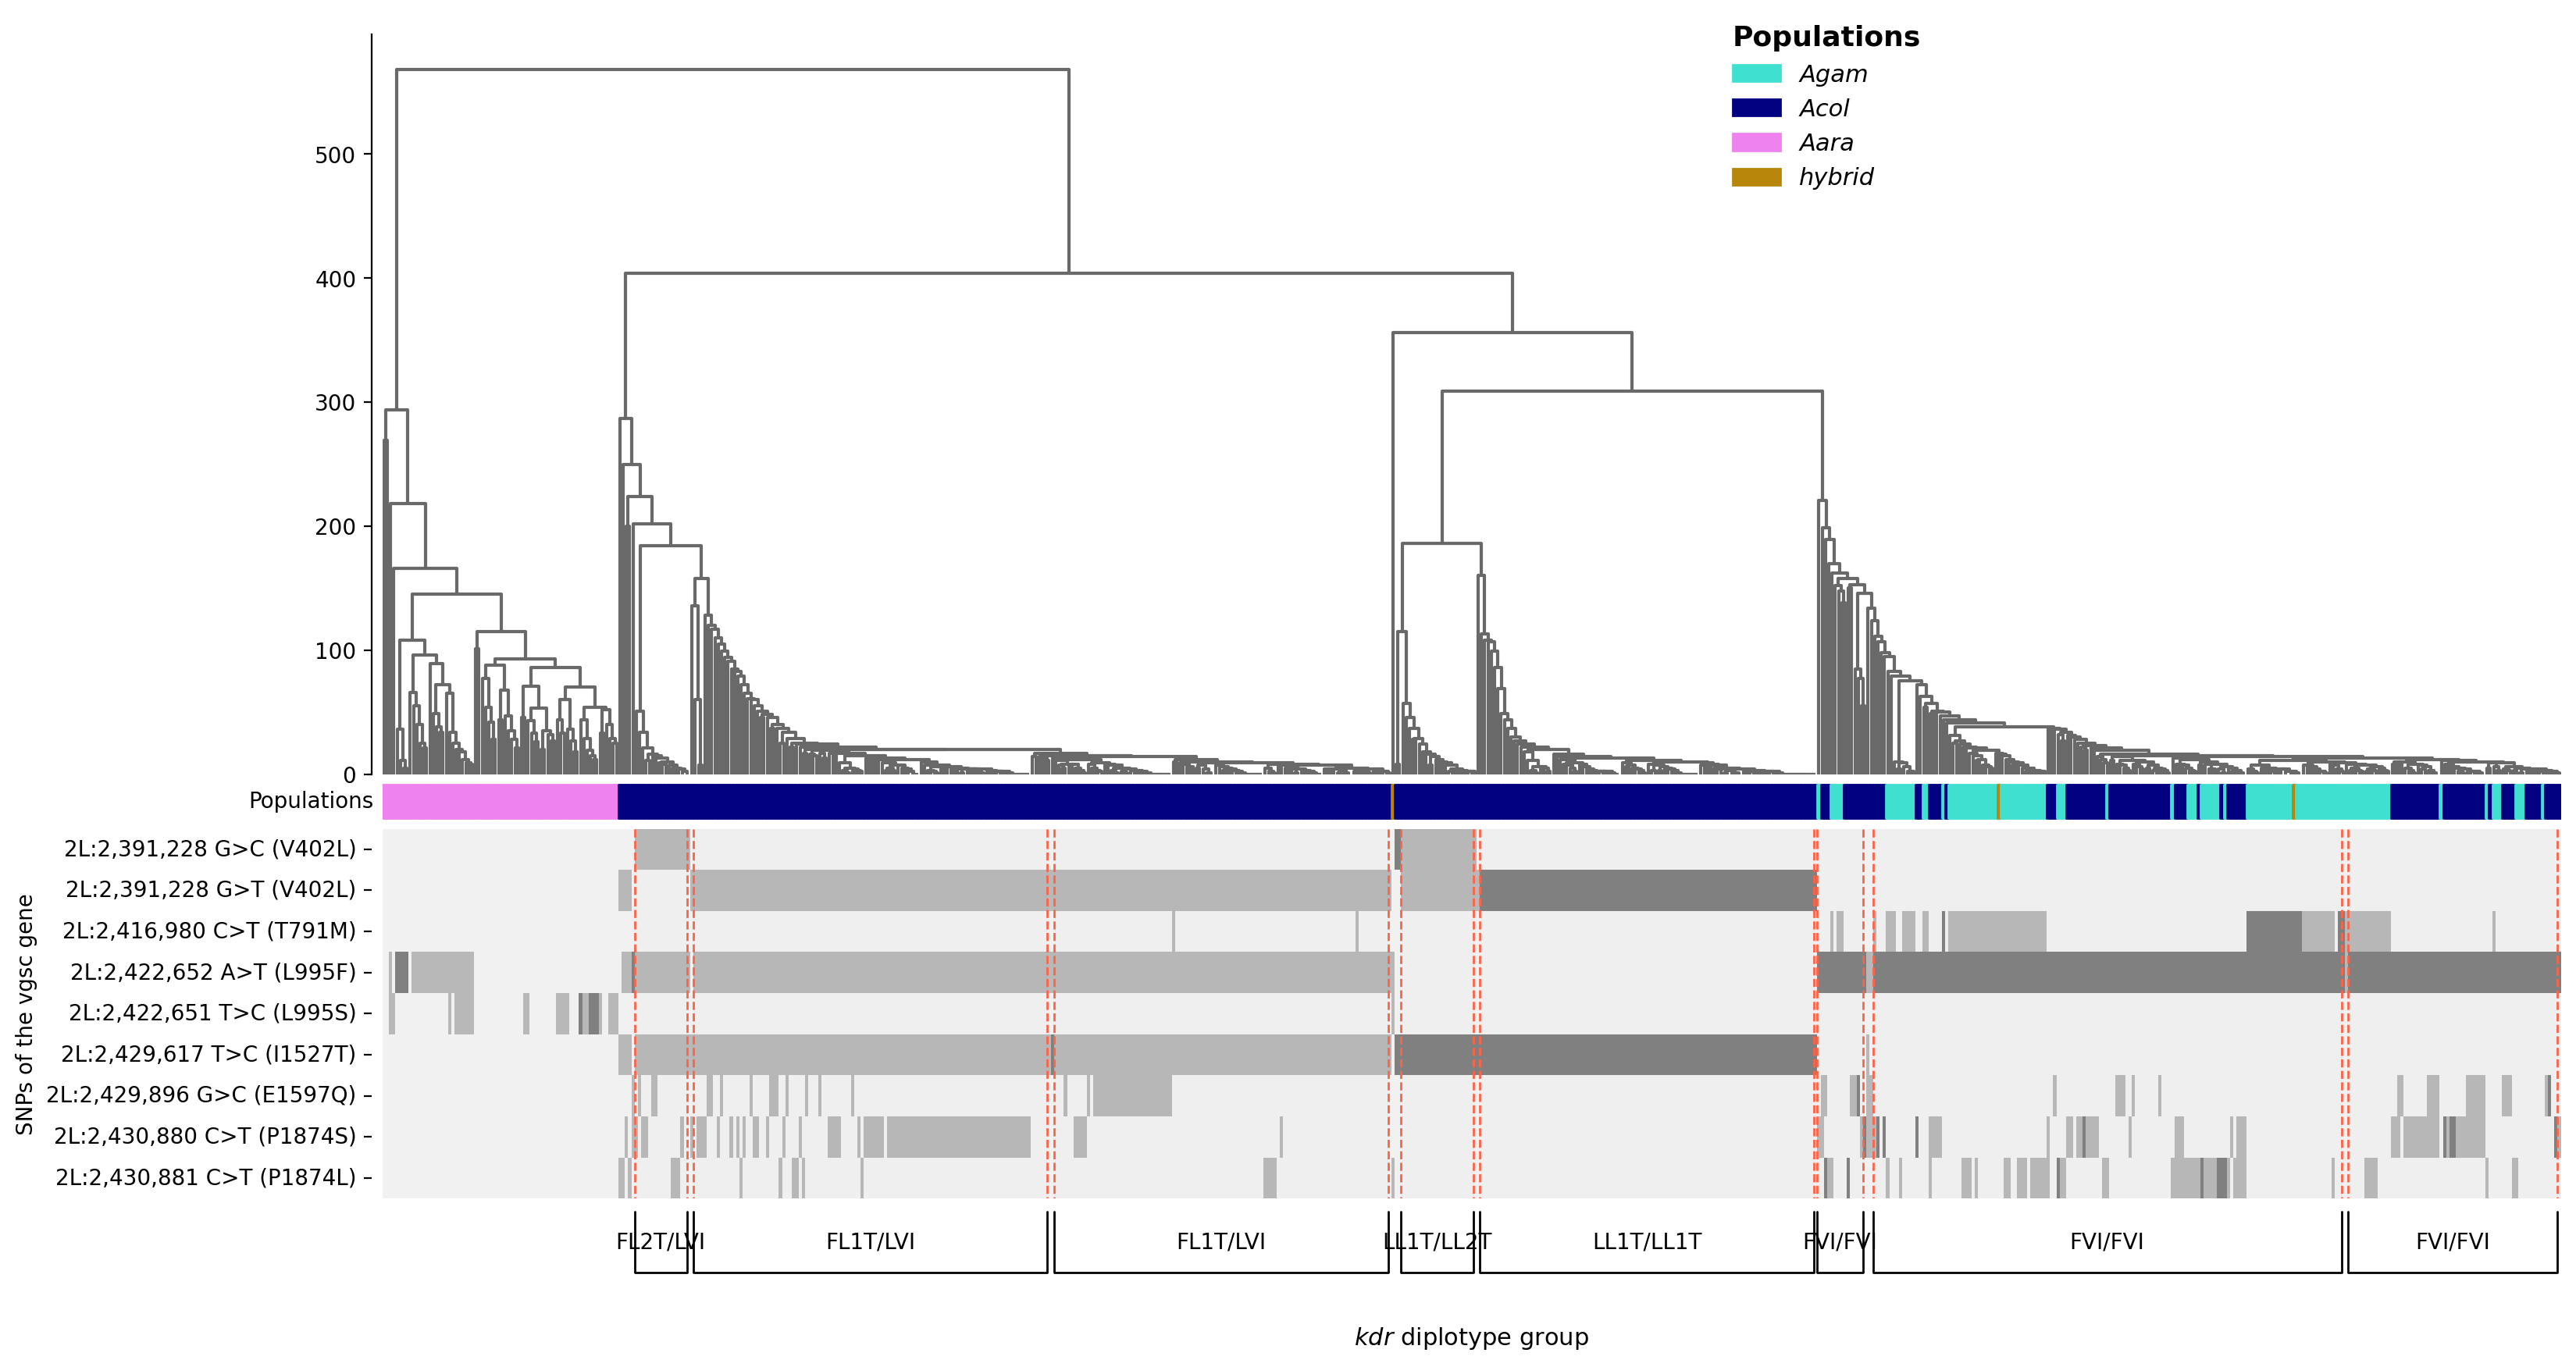

In [40]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
#ax1 = plt.subplot(gs[1, 0])
#ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
##plt.xlim(0,n_leaves)
#plt.axis('off')

ax2 = plt.subplot(gs[1, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=color_maps1)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Populations',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[2, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
#cluster_labels = ['FT/LI', 'LT/VT', 'LT/LT', 'FF/FF', 'FLT/LVI','FLT/LVI']
cluster_labels = ['','FL2T/LVI','FL1T/LVI','FL1T/LVI','LL1T/LL2T','LL1T/LL1T','FVI/FVI','FVI/FVI','FVI/FVI']
#cluster_labels = [f'C{i}' for i in range(len(vspans))]
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[3, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=10)
    #ax3.vlines([xmin, xmax], 0, 1, linestyle='--', color='tomato')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.01,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1, colors='tomato')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
ax_clu.text(df_het.shape[1]/2, -3, '$kdr$ diplotype group', va='top', ha='center', fontsize=11)
    #ax_clu.set_xlabel('$kdr$ diplotype group')

#plt.text(0.8,0.9, 'FT/LI', size=11,transform=ax1.transAxes,
#         bbox=dict(facecolor='dodgerblue', edgecolor='dodgerblue', alpha=0.4, boxstyle='square', pad=0.2))


sf = list(ag_dict.keys())
ccmap = dict(zip(sf, sp_col))
handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
fig.legend(title='Populations', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
#handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
#aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',ncol=2,
#              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.9, 0.9),frameon=False)
#ax0.add_artist(aleg)



plt.show()
#fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/clust_fig12_all.png',dpi=300, bbox_inches='tight')

In [41]:
for key in haplo_sample_id.keys():
  print(key, len(haplo_sample_id[key]))

FVI/FVI 229
FL1T/LVI 215
LL1T/LL1T 103
LL1T/LL2T 23
FL2T/LVI 17
OD 78


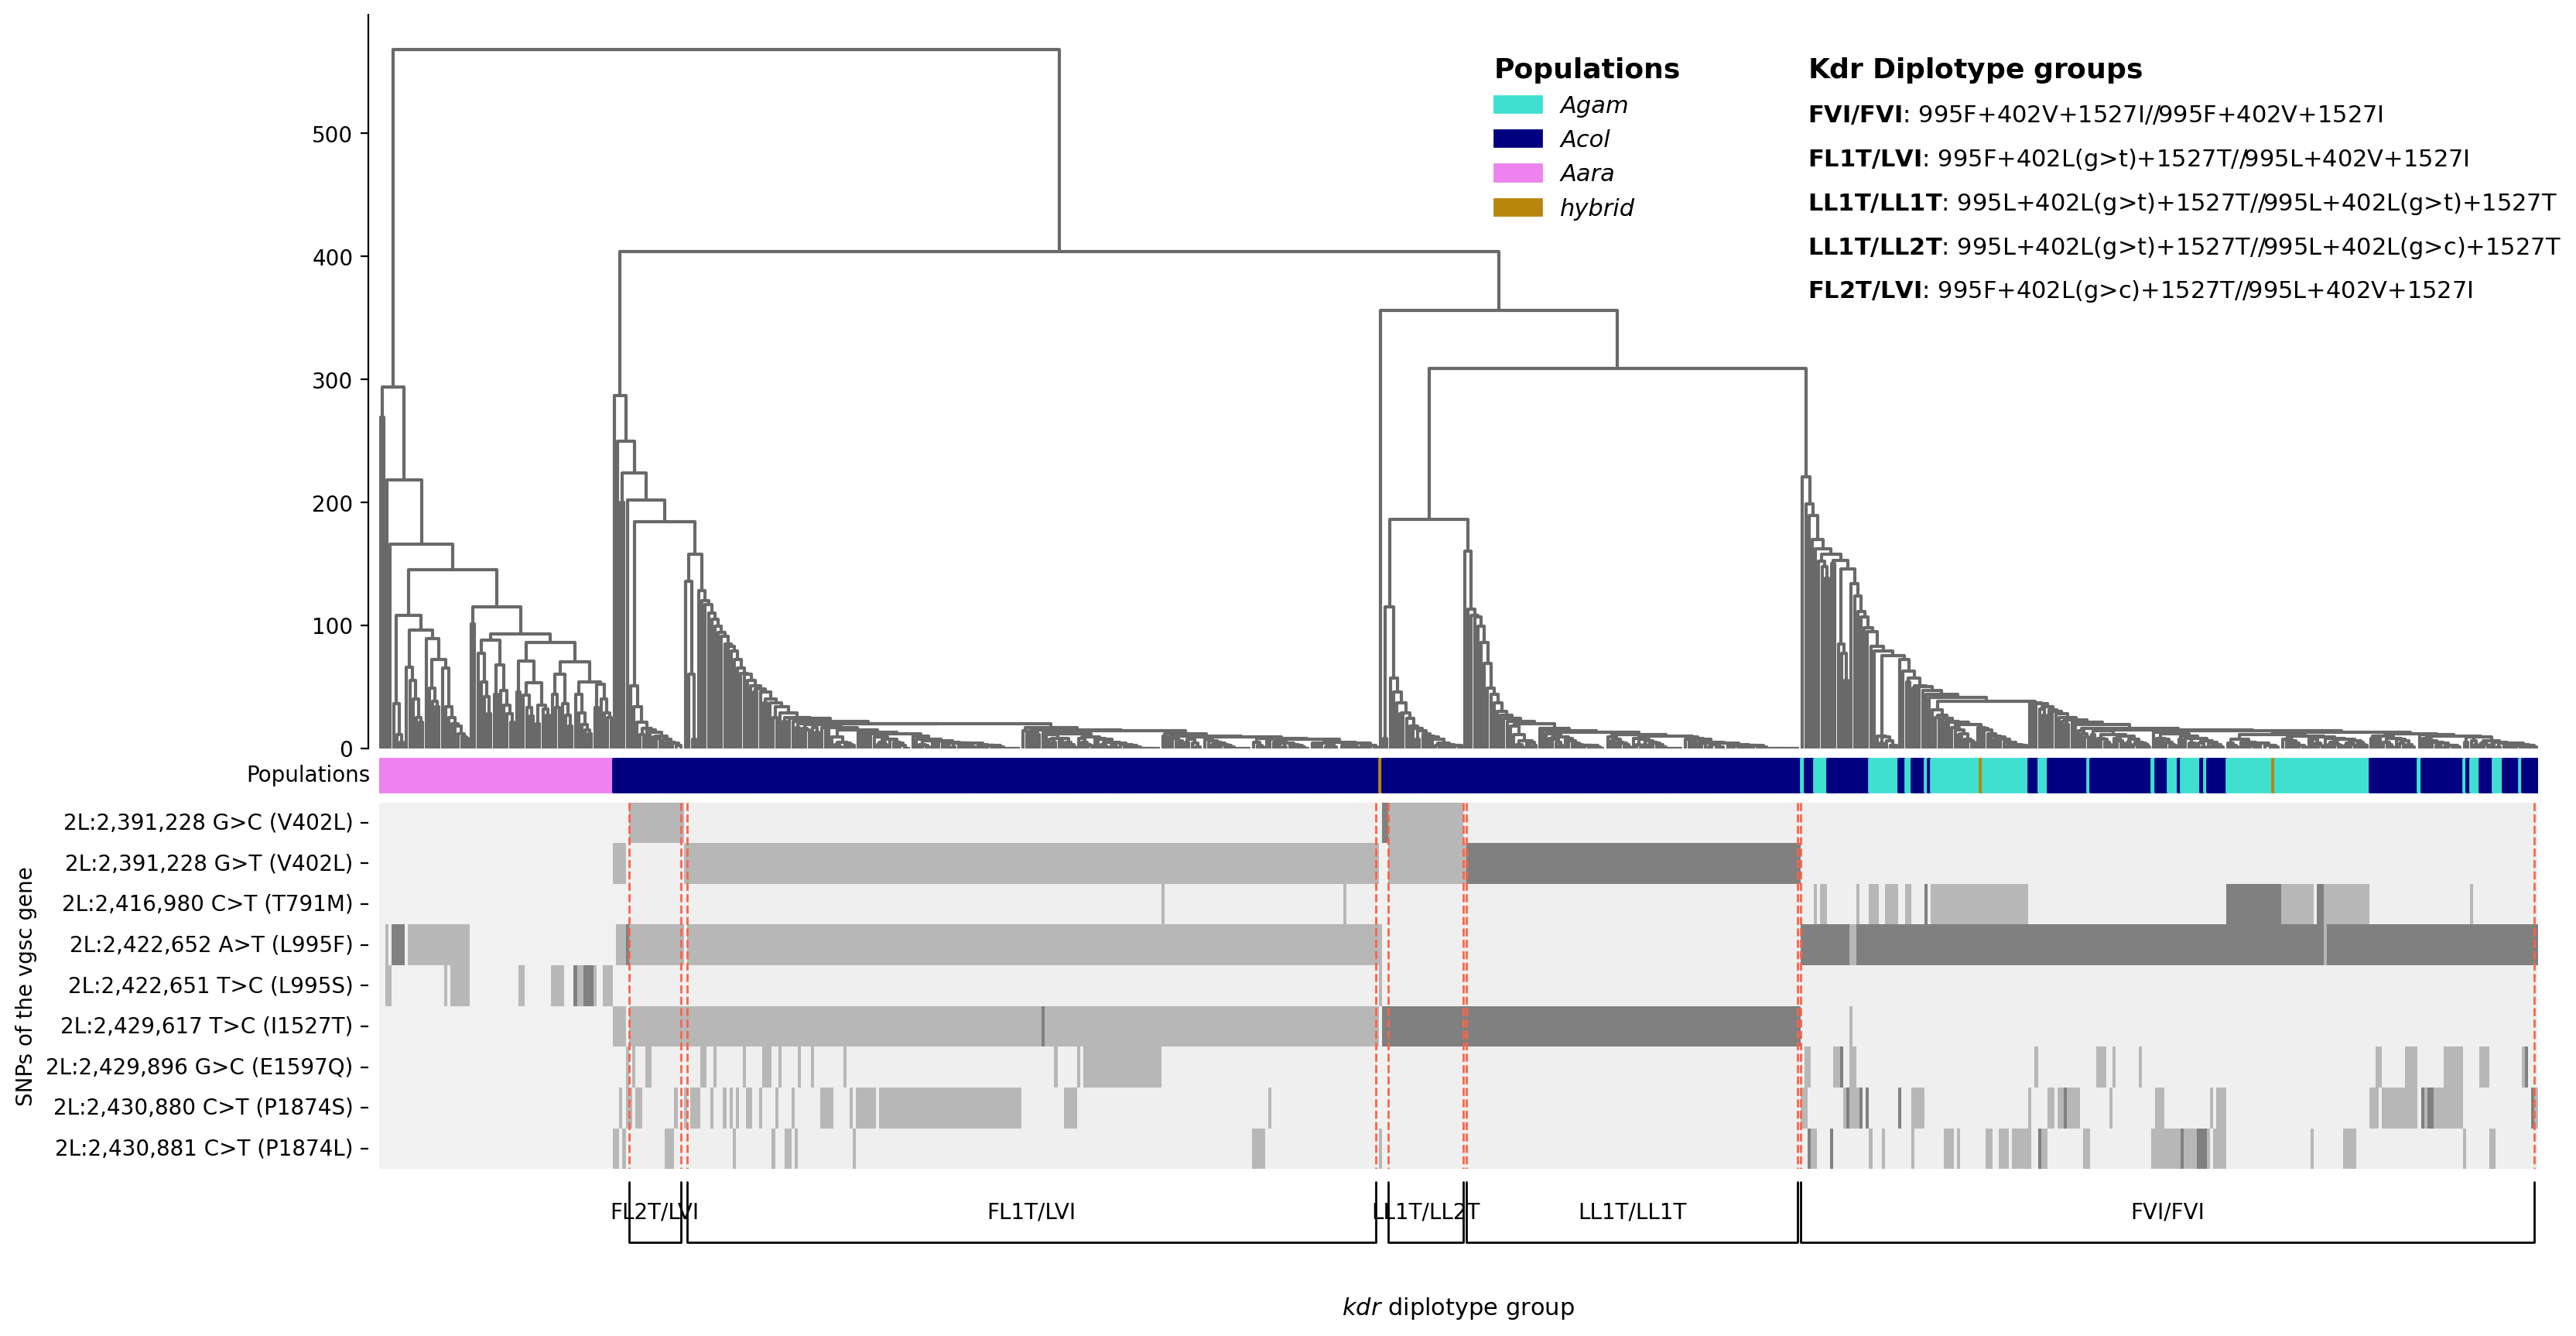

In [48]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
#ax1 = plt.subplot(gs[1, 0])
#ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
##plt.xlim(0,n_leaves)
#plt.axis('off')

ax2 = plt.subplot(gs[1, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=color_maps1)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Populations',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[2, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
#cluster_labels = ['FT/LI', 'LT/VT', 'LT/LT', 'FF/FF', 'FLT/LVI','FLT/LVI']
cluster_labels = ['','FL2T/LVI','FL1T/LVI','LL1T/LL2T','LL1T/LL1T','FVI/FVI']
#cluster_labels = [f'C{i}' for i in range(len(vspans))]
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[3, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans_mod):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=10)
    #ax3.vlines([xmin, xmax], 0, 1, linestyle='--', color='tomato')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.01,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1, colors='tomato')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
ax_clu.text(df_het.shape[1]/2, -3, '$kdr$ diplotype group', va='top', ha='center', fontsize=11)
    #ax_clu.set_xlabel('$kdr$ diplotype group')

plt.text(440,37, r'$\mathbf{FVI/FVI}$: 995F+402V+1527I//995F+402V+1527I', size=11)
plt.text(440,35.5, r'$\mathbf{FL1T/LVI}$: 995F+402L(g>t)+1527T//995L+402V+1527I', size=11)
plt.text(440,34, r'$\mathbf{LL1T/LL1T}$: 995L+402L(g>t)+1527T//995L+402L(g>t)+1527T', size=11)
plt.text(440,32.5, r'$\mathbf{LL1T/LL2T}$: 995L+402L(g>t)+1527T//995L+402L(g>c)+1527T', size=11)
plt.text(440,31, r'$\mathbf{FL2T/LVI}$: 995F+402L(g>c)+1527T//995L+402V+1527I', size=11)
plt.text(440,38.5, r'$\mathbf{Kdr}$ $\mathbf{Diplotype}$ $\mathbf{groups}$', size=13)


sf = list(ag_dict.keys())
ccmap = dict(zip(sf, sp_col))
handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
fig.legend(title='Populations', labels=leg_labels, handles=handles,bbox_to_anchor=(0.6, 0.867),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
#handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
#aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',ncol=2,
#              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.9, 0.9),frameon=False)
#ax0.add_artist(aleg)

plt.show()
fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/clust_fig12_all_no_OD.png',dpi=300, bbox_inches='tight')

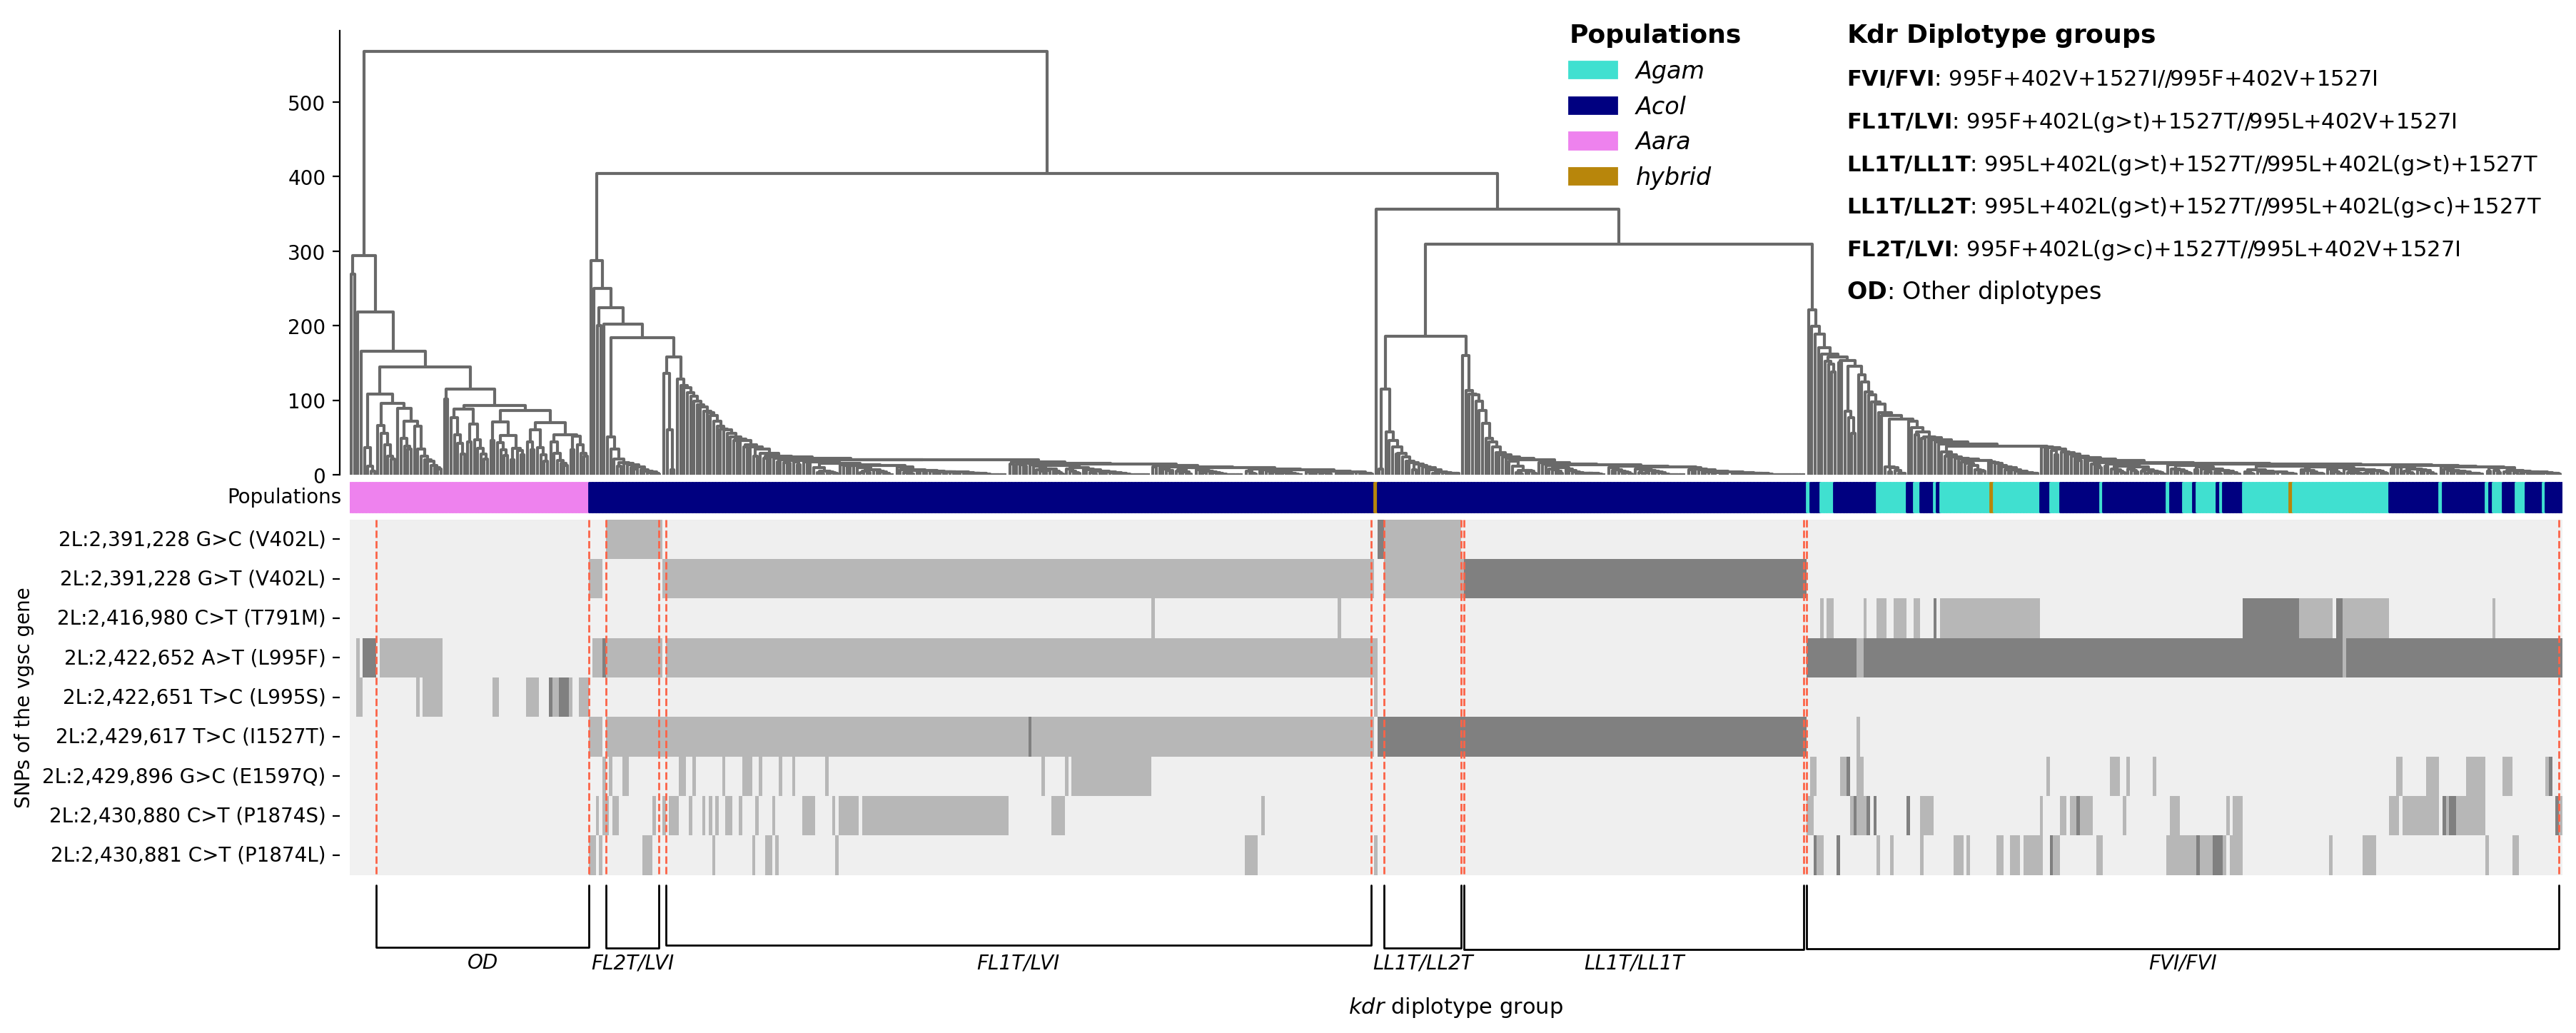

In [47]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(1.25,0.09,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
#ax1 = plt.subplot(gs[1, 0])
#ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
##plt.xlim(0,n_leaves)
#plt.axis('off')

ax2 = plt.subplot(gs[1, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=color_maps1)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Populations',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[2, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
#cluster_labels = ['FT/LI', 'LT/VT', 'LT/LT', 'FF/FF', 'FLT/LVI','FLT/LVI']
cluster_labels = ['OD','FL2T/LVI','FL1T/LVI','LL1T/LL2T','LL1T/LL1T','FVI/FVI']
#cluster_labels = [f'C{i}' for i in range(len(vspans))]
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[3, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans_mod):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.2f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, -1.5, lbl, va='top', ha='center', fontsize=10, fontstyle='italic')
    #ax3.vlines([xmin, xmax], 0, 1, linestyle='--', color='tomato')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.01,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1, colors='tomato')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
ax_clu.text(df_het.shape[1]/2, -3, '$kdr$ diplotype group', va='top', ha='center', fontsize=11)
    #ax_clu.set_xlabel('$kdr$ diplotype group')

plt.text(450,29, r'$\mathbf{FVI/FVI}$: 995F+402V+1527I//995F+402V+1527I', size=11)
plt.text(450,27.5, r'$\mathbf{FL1T/LVI}$: 995F+402L(g>t)+1527T//995L+402V+1527I', size=11)
plt.text(450,26, r'$\mathbf{LL1T/LL1T}$: 995L+402L(g>t)+1527T//995L+402L(g>t)+1527T', size=11)
plt.text(450,24.5, r'$\mathbf{LL1T/LL2T}$: 995L+402L(g>t)+1527T//995L+402L(g>c)+1527T', size=11)
plt.text(450,23, r'$\mathbf{FL2T/LVI}$: 995F+402L(g>c)+1527T//995L+402V+1527I', size=11)
plt.text(450,21.5, r'$\mathbf{OD}$: Other diplotypes', size=12)
plt.text(450,30.5, r'$\mathbf{Kdr}$ $\mathbf{Diplotype}$ $\mathbf{groups}$', size=13)

#plt.text(480,29, r'$\mathbf{FF/FF}$: 995F/995F', size=12)
#plt.text(480,27.5, r'$\mathbf{FLT/LVI}$: 995F+402L+1527T/995L+402V+1527I', size=12)
#plt.text(480,26, r'$\mathbf{LT/LT}$: 402L+1527T/402L+1527T', size=12)
#plt.text(480,24.5, r'$\mathbf{LT/VT}$: 402L+1527T/402V+1527T', size=12)
#plt.text(480,23, r'$\mathbf{FT/LI}$: 995F+1527T/995L+1527I', size=12)
#plt.text(480,30.5, r'$\mathbf{Kdr}$ $\mathbf{Diplotype}$ $\mathbf{groups}$', size=13)
#plt.text(480,21.5, r'$\mathbf{OD}$: Other diplotypes', size=12)

sf = list(ag_dict.keys())
ccmap = dict(zip(sf, sp_col))
handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
fig.legend(title='Populations', labels=leg_labels, handles=handles,bbox_to_anchor=(0.62, 0.905),frameon=False,
          prop={'size':12, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
#handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
#aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',ncol=2,
#              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.9, 0.9),frameon=False)
#ax0.add_artist(aleg)



plt.show()
fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/clust_fig12_all_with_OD.png',dpi=300, bbox_inches='tight')

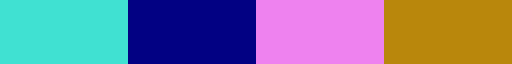

In [44]:
color_maps

(np.float64(0.0), np.float64(665.0), np.float64(-0.05), np.float64(1.05))

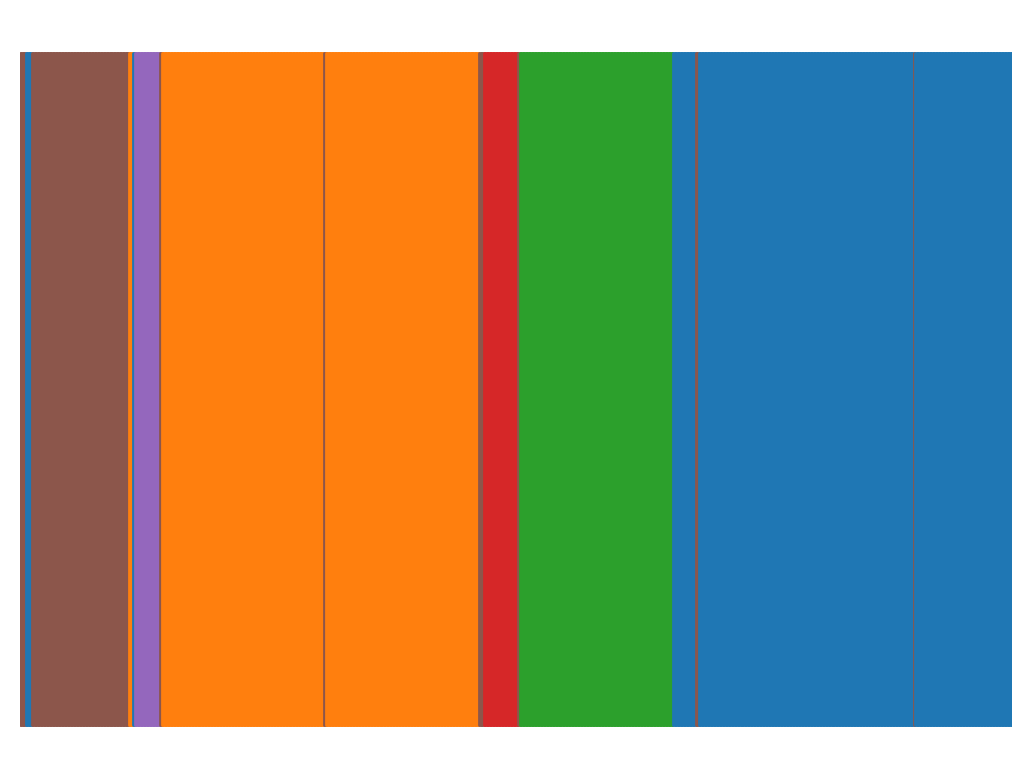

In [45]:
plt.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
#handles, labels = plt.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

In [46]:
#hap_labels